In [1]:
!nvidia-smi

Mon Sep  7 04:19:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 20%   35C    P0    32W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

First, we grab matplotlib, and set the old "classic" style for some reason only Rui knows.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('classic')

In [3]:
import numpy as np
import torch

These are the local imports. Make sure you import the correct model!

In [4]:
## from model.models import SimpleCNN4Layer_D35_sp as Model
from model.models_mds_F import FourFeature_CNN6Layer_D as Model
##from model.collectdata import collect_data, collect_truth
from model.collectdata_mdsA import collect_data, collect_truth
from model.training import select_gpu
from model.plots_mdsA import plot_ruiplot
from model.efficiency import pv_locations, efficiency
from model.core import modernize

Select a GPU here. Same numbering as the NVidia-SMI tool.

In [5]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


Pick a file to load.

In [6]:
verbose = False

In [7]:
validation = collect_data('dataAA/Oct03_20K_val.h5',
                          batch_size=1,
                          slice=slice(500),
                          masking=True, shuffle=False,
                          device=device,
                          load_XandXsq=True,
                          load_xy=True)



Loading data...
Loaded dataAA/Oct03_20K_val.h5 in 5.334 s
Constructing 500 event dataset took 2.108 s


In [8]:
import h5py
XY_file = 'dataAA/Oct03_20K_val.h5'

with h5py.File(XY_file, mode='r') as XY:
    xmax = np.asarray(XY['Xmax'])
    ymax = np.asarray(XY['Ymax'])

> Note: to get the real PV locations, use `collect_truth('file.h5', pvs=True)` to collect PVs (or SVs with `pvs=False`)

Let's just see how many NaNs we have in the dataset.

In [9]:
if verbose:
    print(*np.sum(np.isnan(validation.dataset.tensors[1].cpu().numpy()), 1))

In [10]:
PV = collect_truth('dataAA/Oct03_20K_val.h5', pvs=True)
if verbose:
    print('PV.n.shape =    ',  PV.n.shape)
    print('PV.n[0].shape = ', *PV.n[0].shape)
    print('PV.x[0] =       ', *PV.x[0])
    print('PV.y[0] =       ', *PV.y[0])
    print('PV.z[0] =       ', *PV.z[0])
    print('PV.n[0] =       ', *PV.n[0])
    print('PV.cat[0] =     ', *PV.cat[0])

Loaded dataAA/Oct03_20K_val.h5 in 0.03125 s


In [11]:
if verbose:
    PV.n.max().max()

In [12]:
if verbose:
    PV.cat[0]

In [13]:
SV = collect_truth('dataAA/Oct03_20K_val.h5', pvs=False)
if verbose:
    print('SV.n.shape =    ', SV.n.shape)
    print('SV.n[0].shape = ', *SV.n[0].shape)
    print('SV.x[0] =       ', *SV.x[0])
    print('SV.y[0] =       ', *SV.y[0])
    print('SV.z[0] =       ', *SV.z[0])
    print('SV.n[0] =       ', *SV.n[0])
    print('SV.cat[0] =     ', *SV.cat[0])

Loaded dataAA/Oct03_20K_val.h5 in 0.0229 s


Select a model to load. Make sure it matches the model you imported above.

> #### Mike note:
>
> If you use an old-style model, comment out the `d = modernize(d, 3)` line - that converts the old model key names to the new format.

In [14]:
#name = '/share/lazy/schreihf/PvFinder/models/Dec11_SimpleCNN4Layer_D35_sp_first200epochs_240K_lr_3em5_bs512_Alt_Loss_A_4p5_final.pyt'
##name = '/home/sokoloff/pv-finder/notebooks/Dec21_SimpleCNN4Layer_D35_sp_yetAnother200epochs_240K_lr_1em3_bs512_Alt_Loss_A_4p5/Dec21_SimpleCNN4Layer_D35_sp_yetAnother200epochs_240K_lr_1em3_bs512_Alt_Loss_A_4p5_final.pyt'
##name = '/home/sokoloff/pv-finder/notebooks/Dec21_SimpleCNN4Layer_D35_sp_yetAnother600epochs_240K_lr_3em4_bs512_Alt_Loss_A_4p5/Dec21_SimpleCNN4Layer_D35_sp_yetAnother600epochs_240K_lr_3em4_bs512_Alt_Loss_A_4p5_final.pyt'
name = 'ML/Aug10_FourFeature_CNN6LayerPlus_TargetsA_First20epochs_160K_lr_1em3_bs64_Alt_Loss_A_3p0/Aug10_FourFeature_CNN6LayerPlus_TargetsA_First20epochs_160K_lr_1em3_bs64_Alt_Loss_A_3p0_final.pyt'
name = 'ML/Aug11_FourFeature_CNN6LayerPlus_TargetsAA_First40epochs_fixedPert_160K_lr_1em3_bs64_Alt_Loss_A_3p0/Aug11_FourFeature_CNN6LayerPlus_TargetsAA_First40epochs_fixedPert__160K_lr_1em3_bs64_Alt_Loss_A_3p0_final.pyt'
name = 'ML/Aug14_FourFeature_CNN6LayerPlus_TargetsAA_400epochs_160K_lr_3em4_bs64_Alt_Loss_A_3p0/Aug14_FourFeature_CNN6LayerPlus_TargetsAA_400epochs_160K_lr_3em4_bs64_Alt_Loss_A_3p0_399.pyt'
name = 'ML/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5_final.pyt'
model = Model().to(device)
d = torch.load(name)
d = modernize(d, 3) # Only use if using the new Model definitions (should be safe if not, but unneccisary)
model.load_state_dict(d)
model.eval()

FourFeature_CNN6Layer_D(
  (conv1): Conv1d(2, 25, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4of6): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5of6): Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 10, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(10, 5, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (ppFc1): Linear(in_features=4000, out_features=4000, bias=True)
  (ppFinalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropou

Let's grab the model outputs (predicted KDEs bins position) and labels (generated KDEs bins positions) as normal numpy arrays.

In [15]:
##%%time
with torch.no_grad():
    predict_outputs = model(validation.dataset.tensors[0]).cpu().numpy()
    truth_inputs = validation.dataset.tensors[1].cpu().numpy()

#if verbose:
for i in range(len(predict_outputs[0])):
    print('model predictions = ', predict_outputs[0][i])
    print('truth inputs 1 = ',truth_inputs[0][i])


model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predict

truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 

model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predict

model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predict

truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 

model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predictions =  0.0
truth inputs 1 =  0.0
model predict

And here's Rui's plotting code.

In [16]:
test = validation.dataset.tensors[0].cpu().numpy()
if verbose:
    print('test.shape = ',test.shape)

[34 10  4 23  4 29  4]
4000
truth_pv_loc =  [ 633.58777 1489.0426  1800.5101  2634.3743 ]
truth =  [ 634 1489 1801 2634]
computed =  [ 633 1010 1490 1799 2274 2634]
poi =  [ 633  634 1010 1489 1490 1799 1801 2274 2634 2634]
poi =  [ 633 1010 1489 1799 2274 2634]

Event 0: Found 4 of 4, added 1 (eff 100.00%)
truth_centroid =  [-36.641224]
truth_pv_loc[b_truth] =  [633.58777]
b_truth =  [ True False False False]
truth_pv_loc =  [ 633.58777 1489.0426  1800.5101  2634.3743 ]

comp_centroid =  [-36.713734]
predict_pv_loc[b_comp] =  [632.8627]
b_comp =  [ True False False False False False]
predict_pv_loc =  [ 632.8627 1009.7908 1489.54   1799.4791 2273.6482 2633.9077]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [-0.72509766]

Event 0.0:
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]

PV: 23 tracks (type 1)
  x:   -35 μm
  y:    44 μm
  z:  -36.592 mm
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]

SV: 1 tracks (type 0

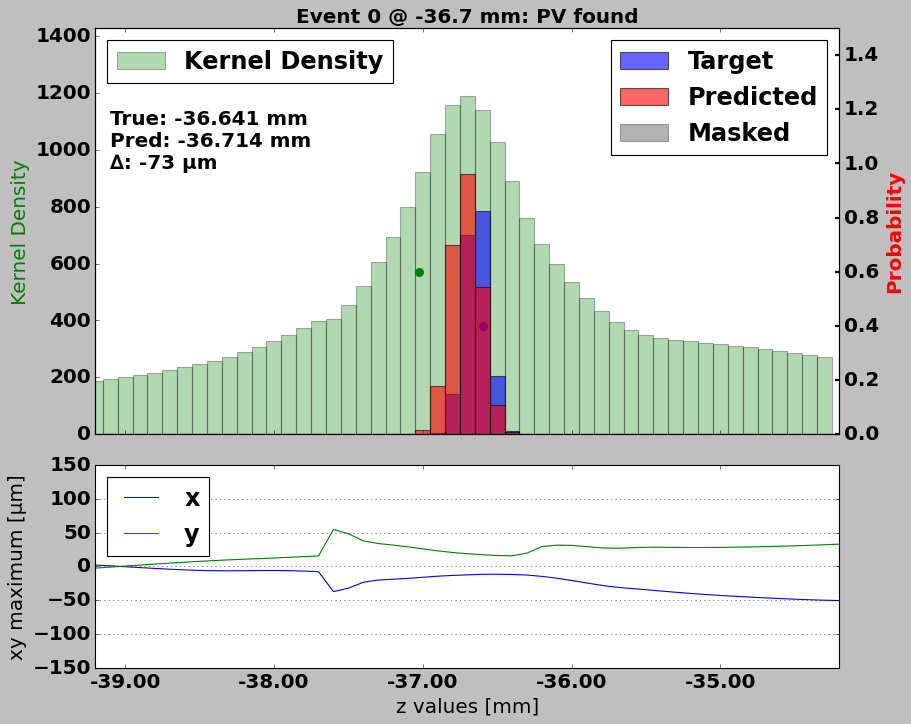

truth_centroid =  []
truth_pv_loc[b_truth] =  []
b_truth =  [False False False False]
truth_pv_loc =  [ 633.58777 1489.0426  1800.5101  2634.3743 ]

comp_centroid =  [0.9790802]
predict_pv_loc[b_comp] =  [1009.7908]
b_comp =  [False  True False False False False]
predict_pv_loc =  [ 632.8627 1009.7908 1489.54   1799.4791 2273.6482 2633.9077]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  []

Event 0.1:
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]

PV: 4 tracks (type 0)
  x:     2 μm
  y:   -32 μm
  z:    1.054 mm
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]


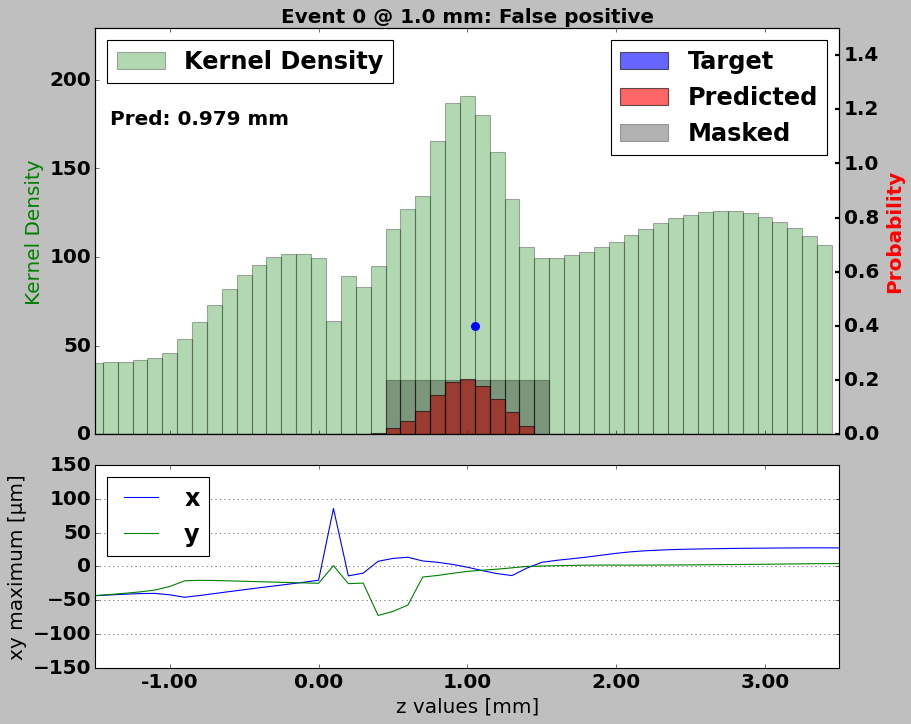

truth_centroid =  [48.904266]
truth_pv_loc[b_truth] =  [1489.0426]
b_truth =  [False  True False False]
truth_pv_loc =  [ 633.58777 1489.0426  1800.5101  2634.3743 ]

comp_centroid =  [48.95401]
predict_pv_loc[b_comp] =  [1489.54]
b_comp =  [False False  True False False False]
predict_pv_loc =  [ 632.8627 1009.7908 1489.54   1799.4791 2273.6482 2633.9077]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [0.49743652]

Event 0.2:
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]

PV: 29 tracks (type 1)
  x:    46 μm
  y:   -65 μm
  z:   48.954 mm
[34 10  4 23  4 29  4]


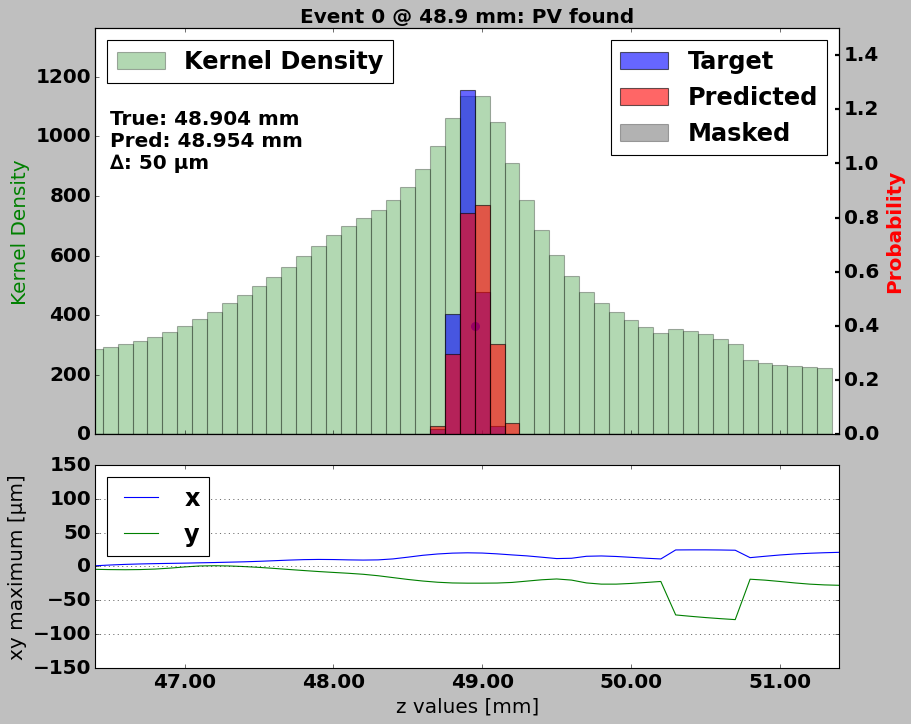

truth_centroid =  [80.05101]
truth_pv_loc[b_truth] =  [1800.5101]
b_truth =  [False False  True False]
truth_pv_loc =  [ 633.58777 1489.0426  1800.5101  2634.3743 ]

comp_centroid =  [79.94791]
predict_pv_loc[b_comp] =  [1799.4791]
b_comp =  [False False False  True False False]
predict_pv_loc =  [ 632.8627 1009.7908 1489.54   1799.4791 2273.6482 2633.9077]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [-1.0310059]

Event 0.3:
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]

PV: 10 tracks (type 1)
  x:   -54 μm
  y:    -1 μm
  z:   80.101 mm
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]


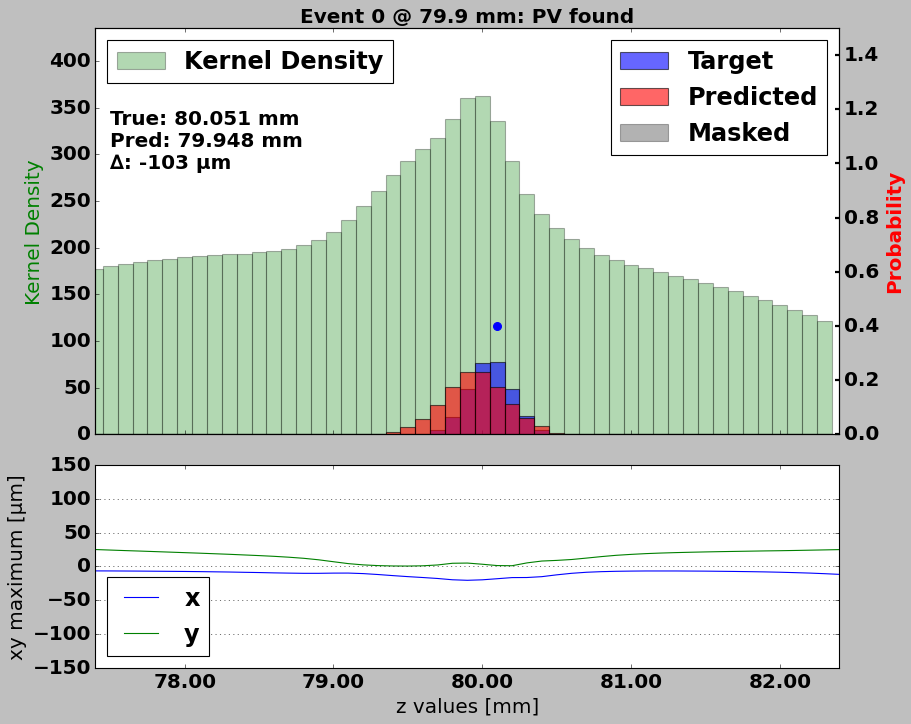

truth_centroid =  []
truth_pv_loc[b_truth] =  []
b_truth =  [False False False False]
truth_pv_loc =  [ 633.58777 1489.0426  1800.5101  2634.3743 ]

comp_centroid =  [127.36482]
predict_pv_loc[b_comp] =  [2273.6482]
b_comp =  [False False False False  True False]
predict_pv_loc =  [ 632.8627 1009.7908 1489.54   1799.4791 2273.6482 2633.9077]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  []

Event 0.4:
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]

PV: 4 tracks (type 0)
  x:   -73 μm
  y:    -5 μm
  z:  126.701 mm


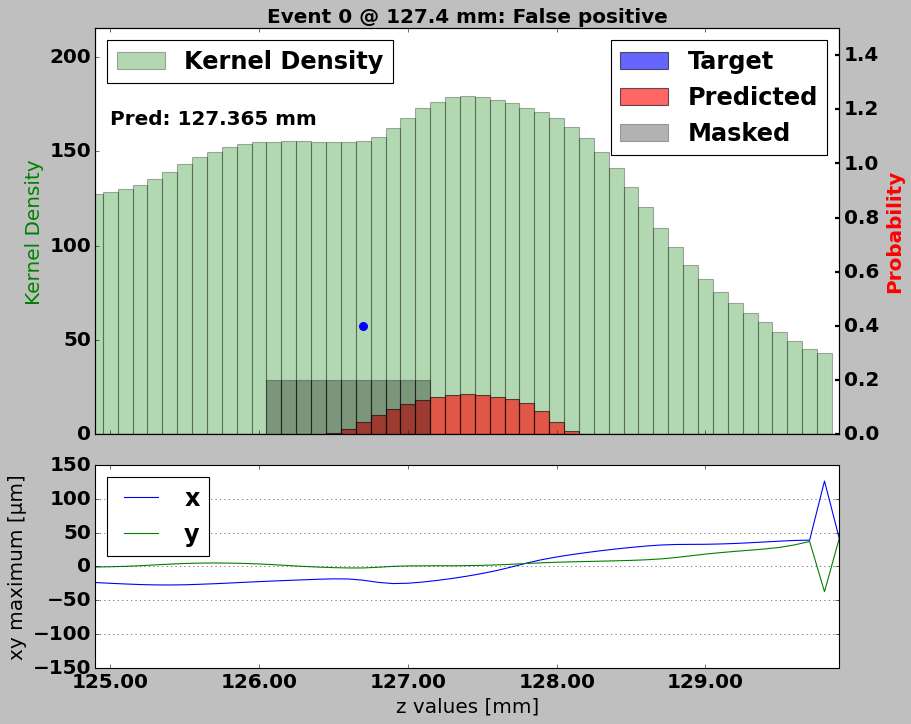

truth_centroid =  [163.43744]
truth_pv_loc[b_truth] =  [2634.3743]
b_truth =  [False False False  True]
truth_pv_loc =  [ 633.58777 1489.0426  1800.5101  2634.3743 ]

comp_centroid =  [163.39078]
predict_pv_loc[b_comp] =  [2633.9077]
b_comp =  [False False False False False  True]
predict_pv_loc =  [ 632.8627 1009.7908 1489.54   1799.4791 2273.6482 2633.9077]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [-0.46655273]

Event 0.5:
[34 10  4 23  4 29  4]

PV: 34 tracks (type 1)
  x:     7 μm
  y:     1 μm
  z:  163.487 mm
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]
[34 10  4 23  4 29  4]

SV: 1 tracks (type 0)
  x:    10 μm
  y:     4 μm
  z:  163.665 mm

SV: 2 tracks (type 1)
  x:    45 μm
  y:   -18 μm
  z:  163.824 mm


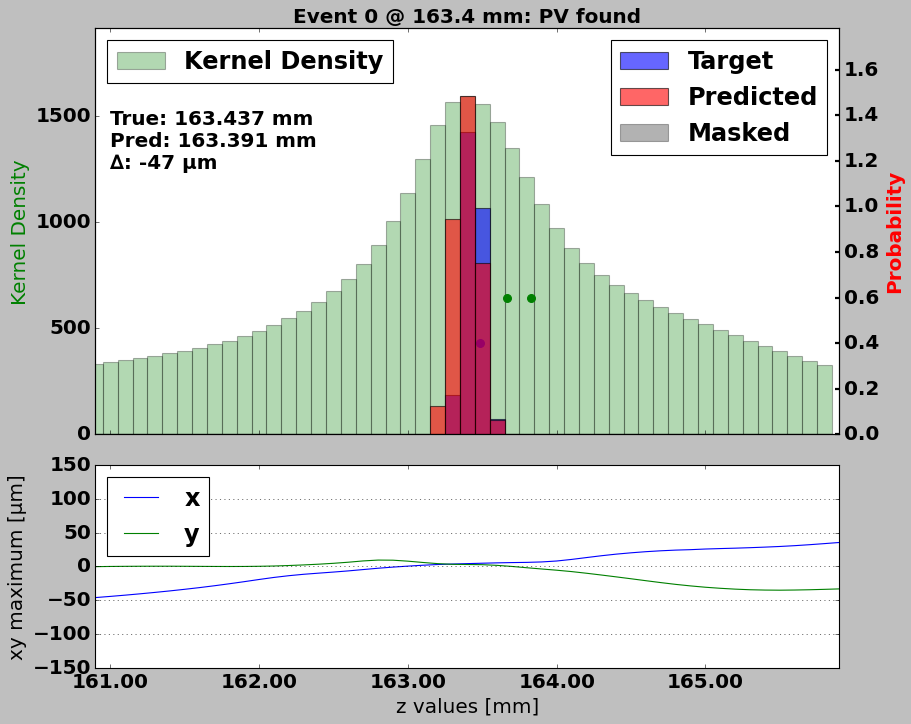

[ 4 17]
4000
truth_pv_loc =  [2415.414]
truth =  [2415]
computed =  [2205 2416]
poi =  [2205 2415 2416]
poi =  [2205 2415]

Event 1: Found 1 of 1, added 1 (eff 100.00%)
truth_centroid =  []
truth_pv_loc[b_truth] =  []
b_truth =  [False]
truth_pv_loc =  [2415.414]

comp_centroid =  [120.49341]
predict_pv_loc[b_comp] =  [2204.934]
b_comp =  [ True False]
predict_pv_loc =  [2204.934  2416.4573]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  []

Event 1.0:
[ 4 17]

PV: 4 tracks (type 0)
  x:    -1 μm
  y:    32 μm
  z:  119.900 mm
[ 4 17]


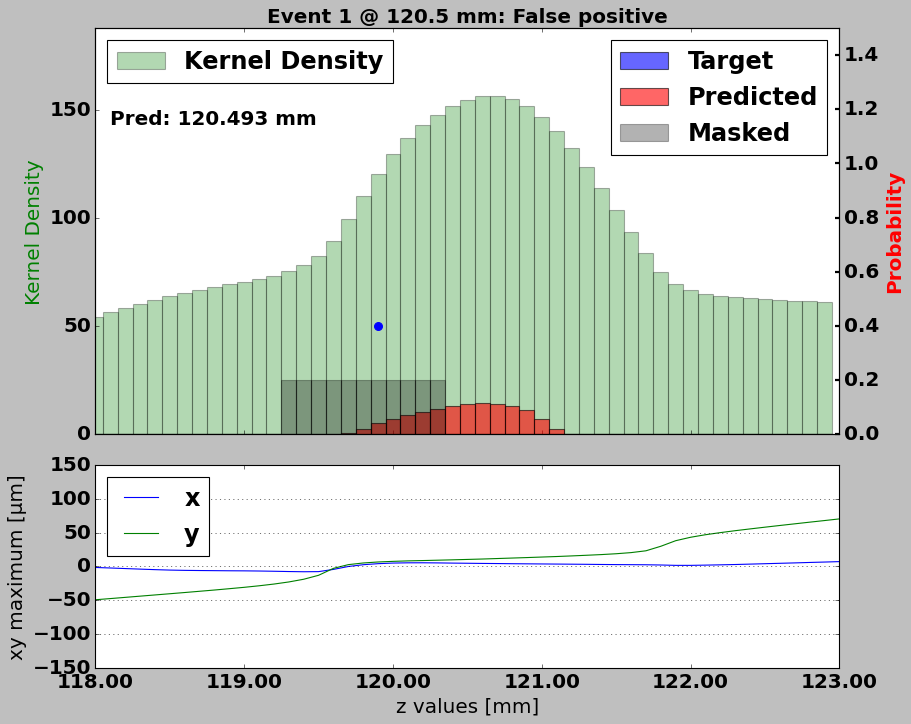

truth_centroid =  [141.54141]
truth_pv_loc[b_truth] =  [2415.414]
b_truth =  [ True]
truth_pv_loc =  [2415.414]

comp_centroid =  [141.64572]
predict_pv_loc[b_comp] =  [2416.4573]
b_comp =  [False  True]
predict_pv_loc =  [2204.934  2416.4573]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [1.0432129]

Event 1.1:
[ 4 17]
[ 4 17]

PV: 17 tracks (type 1)
  x:     0 μm
  y:    -3 μm
  z:  141.591 mm


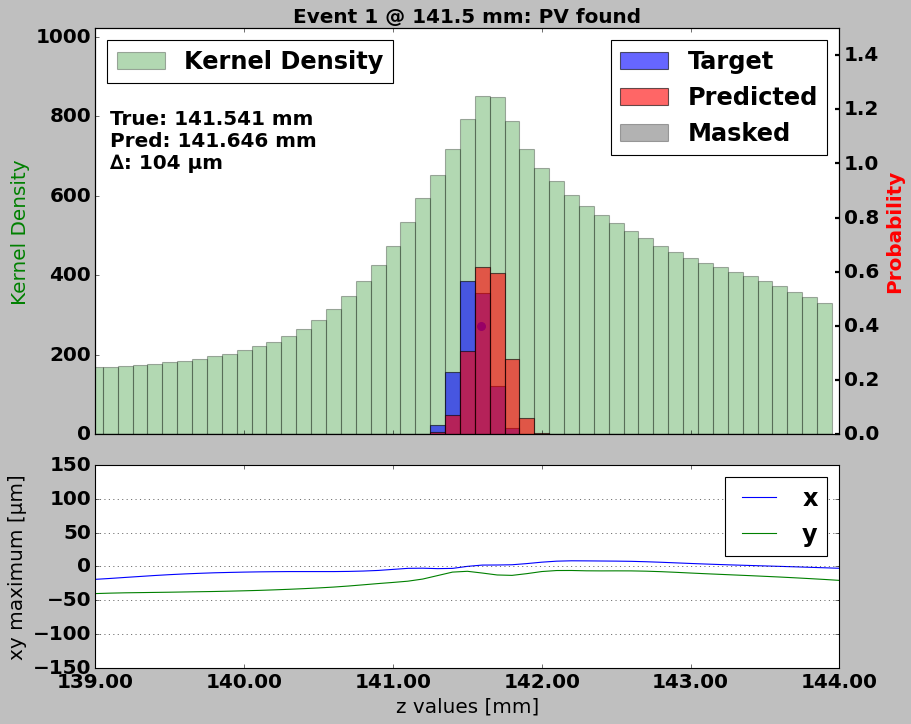

[22  7 41 16 10]
4000
truth_pv_loc =  [ 959.7667 1651.3069 2120.9167 2146.2134 2576.9958]
truth =  [ 960 1651 2121 2146 2577]
computed =  [ 960 1657 2122 2146 2578]
poi =  [ 960  960 1651 1657 2121 2122 2146 2146 2577 2578]
poi =  [ 960 1651 1657 2121 2146 2577]

Event 2: Found 4 of 5, added 1 (eff 80.00%)
truth_centroid =  [-4.0233307]
truth_pv_loc[b_truth] =  [959.7667]
b_truth =  [ True False False False False]
truth_pv_loc =  [ 959.7667 1651.3069 2120.9167 2146.2134 2576.9958]

comp_centroid =  [-4.0176163]
predict_pv_loc[b_comp] =  [959.82385]
b_comp =  [ True False False False False]
predict_pv_loc =  [ 959.82385 1656.9713  2121.6663  2146.1658  2577.7258 ]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [0.05712891]

Event 2.0:
[22  7 41 16 10]

PV: 22 tracks (type 1)
  x:    17 μm
  y:    72 μm
  z:   -3.974 mm
[22  7 41 16 10]
[22  7 41 16 10]
[22  7 41 16 10]
[22  7 41 16 10]


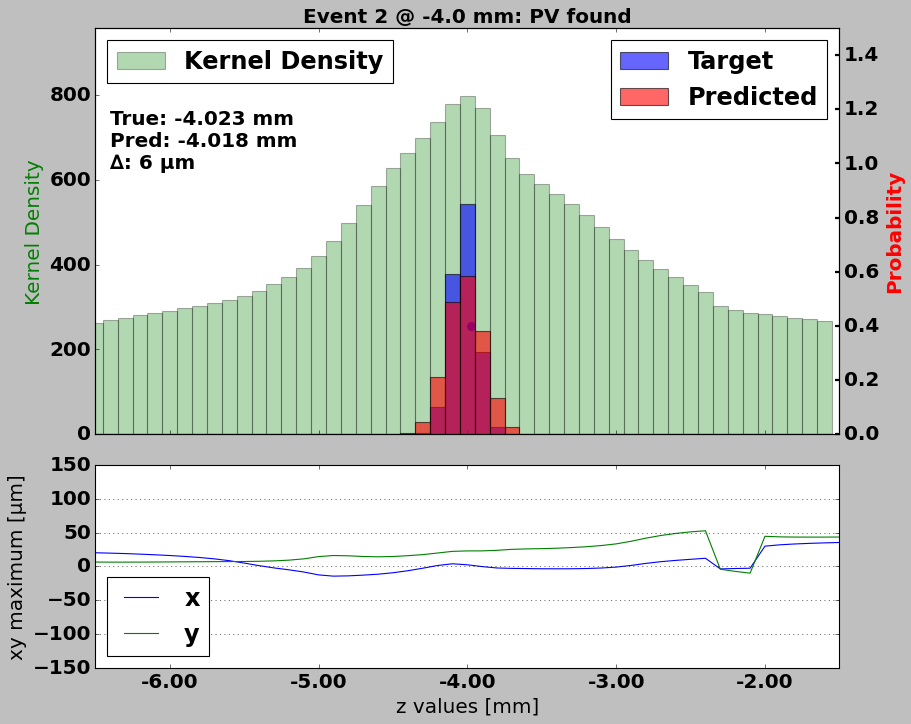

truth_centroid =  [65.13069]
truth_pv_loc[b_truth] =  [1651.3069]
b_truth =  [False  True False False False]
truth_pv_loc =  [ 959.7667 1651.3069 2120.9167 2146.2134 2576.9958]

comp_centroid =  []
predict_pv_loc[b_comp] =  []
b_comp =  [False False False False False]
predict_pv_loc =  [ 959.82385 1656.9713  2121.6663  2146.1658  2577.7258 ]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  []

Event 2.1:
[22  7 41 16 10]
[22  7 41 16 10]
[22  7 41 16 10]
[22  7 41 16 10]
[22  7 41 16 10]

PV: 10 tracks (type 1)
  x:   -22 μm
  y:   -64 μm
  z:   65.180 mm


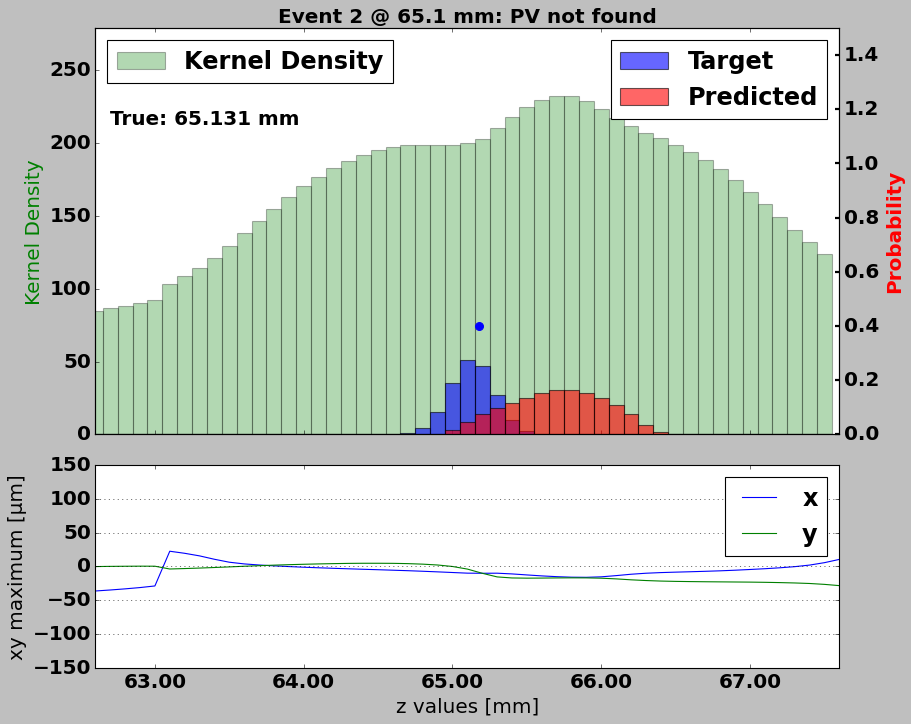

truth_centroid =  []
truth_pv_loc[b_truth] =  []
b_truth =  [False False False False False]
truth_pv_loc =  [ 959.7667 1651.3069 2120.9167 2146.2134 2576.9958]

comp_centroid =  [65.69713]
predict_pv_loc[b_comp] =  [1656.9713]
b_comp =  [False  True False False False]
predict_pv_loc =  [ 959.82385 1656.9713  2121.6663  2146.1658  2577.7258 ]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  []

Event 2.2:
[22  7 41 16 10]
[22  7 41 16 10]
[22  7 41 16 10]
[22  7 41 16 10]
[22  7 41 16 10]

PV: 10 tracks (type 1)
  x:   -22 μm
  y:   -64 μm
  z:   65.180 mm


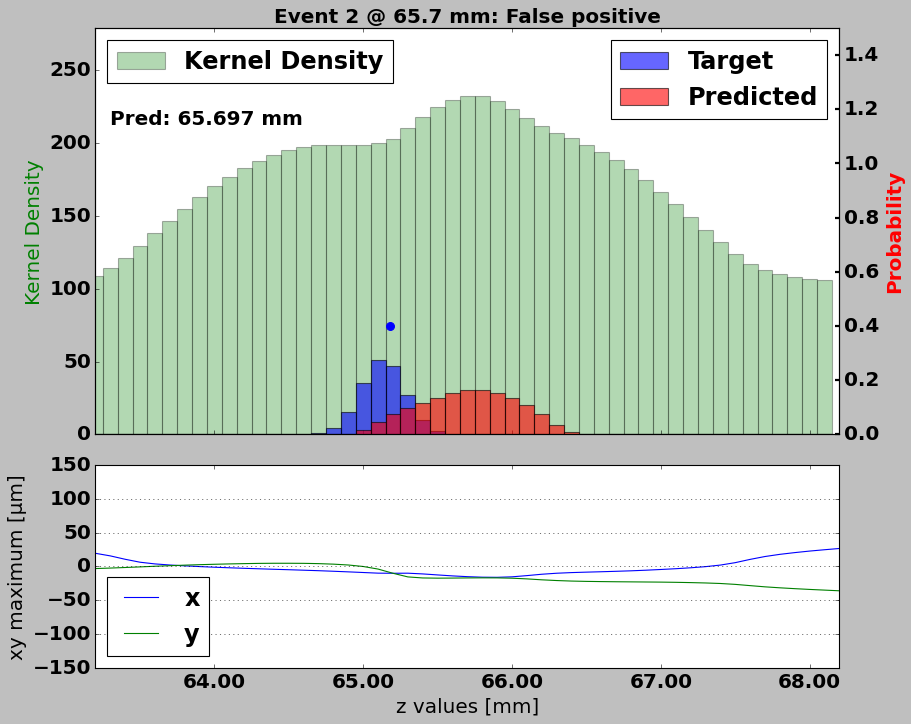

truth_centroid =  [112.091675]
truth_pv_loc[b_truth] =  [2120.9167]
b_truth =  [False False  True False False]
truth_pv_loc =  [ 959.7667 1651.3069 2120.9167 2146.2134 2576.9958]

comp_centroid =  [112.166626]
predict_pv_loc[b_comp] =  [2121.6663]
b_comp =  [False False  True False False]
predict_pv_loc =  [ 959.82385 1656.9713  2121.6663  2146.1658  2577.7258 ]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [0.7495117]

Event 2.3:
[22  7 41 16 10]
[22  7 41 16 10]
[22  7 41 16 10]
[22  7 41 16 10]

PV: 16 tracks (type 1)
  x:     2 μm
  y:   -16 μm
  z:  112.143 mm
[22  7 41 16 10]

SV: 1 tracks (type 0)
  x:    21 μm
  y:   -60 μm
  z:  112.053 mm


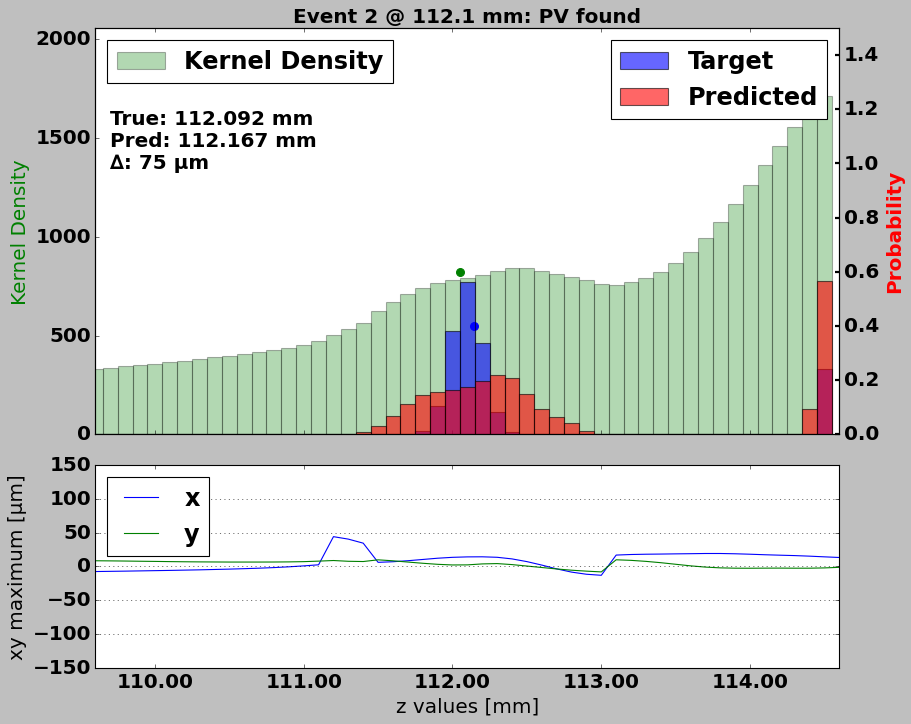

truth_centroid =  [114.62134]
truth_pv_loc[b_truth] =  [2146.2134]
b_truth =  [False False False  True False]
truth_pv_loc =  [ 959.7667 1651.3069 2120.9167 2146.2134 2576.9958]

comp_centroid =  [114.61658]
predict_pv_loc[b_comp] =  [2146.1658]
b_comp =  [False False False  True False]
predict_pv_loc =  [ 959.82385 1656.9713  2121.6663  2146.1658  2577.7258 ]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [-0.04760742]

Event 2.4:
[22  7 41 16 10]
[22  7 41 16 10]
[22  7 41 16 10]

PV: 41 tracks (type 1)
  x:    27 μm
  y:    -7 μm
  z:  114.671 mm
[22  7 41 16 10]

PV: 16 tracks (type 1)
  x:     2 μm
  y:   -16 μm
  z:  112.143 mm
[22  7 41 16 10]


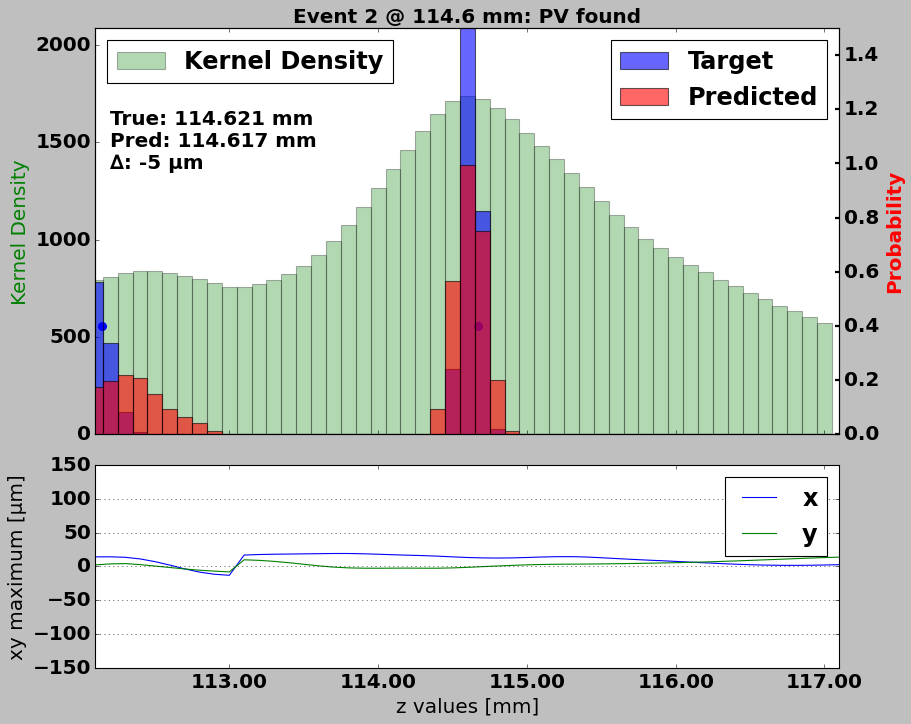

truth_centroid =  [157.69958]
truth_pv_loc[b_truth] =  [2576.9958]
b_truth =  [False False False False  True]
truth_pv_loc =  [ 959.7667 1651.3069 2120.9167 2146.2134 2576.9958]

comp_centroid =  [157.77258]
predict_pv_loc[b_comp] =  [2577.7258]
b_comp =  [False False False False  True]
predict_pv_loc =  [ 959.82385 1656.9713  2121.6663  2146.1658  2577.7258 ]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [0.72998047]

Event 2.5:
[22  7 41 16 10]
[22  7 41 16 10]

PV: 7 tracks (type 1)
  x:   -84 μm
  y:   -16 μm
  z:  157.750 mm
[22  7 41 16 10]
[22  7 41 16 10]
[22  7 41 16 10]


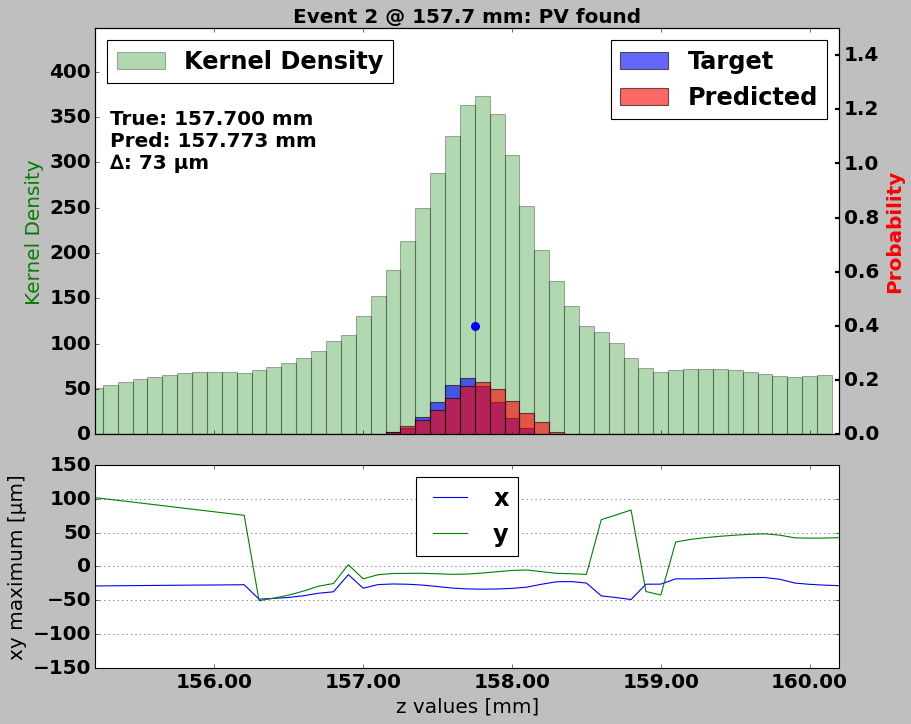

[34 12  2  0  5  5]
4000
truth_pv_loc =  [1206.4215 1518.8698 1565.7228 2763.6868]
truth =  [1206 1519 1566 2764]
computed =  [1206 1566 2762]
poi =  [1206 1206 1519 1566 1566 2762 2764]
poi =  [1206 1519 1566 2762]

Event 3: Found 3 of 4, added 0 (eff 75.00%)
truth_centroid =  [20.64215]
truth_pv_loc[b_truth] =  [1206.4215]
b_truth =  [ True False False False]
truth_pv_loc =  [1206.4215 1518.8698 1565.7228 2763.6868]

comp_centroid =  [20.631897]
predict_pv_loc[b_comp] =  [1206.319]
b_comp =  [ True False False]
predict_pv_loc =  [1206.319  1565.5825 2762.0063]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [-0.10253906]

Event 3.0:
[34 12  2  0  5  5]
[34 12  2  0  5  5]
[34 12  2  0  5  5]
[34 12  2  0  5  5]
[34 12  2  0  5  5]
[34 12  2  0  5  5]

PV: 5 tracks (type 1)
  x:     4 μm
  y:     6 μm
  z:   20.701 mm


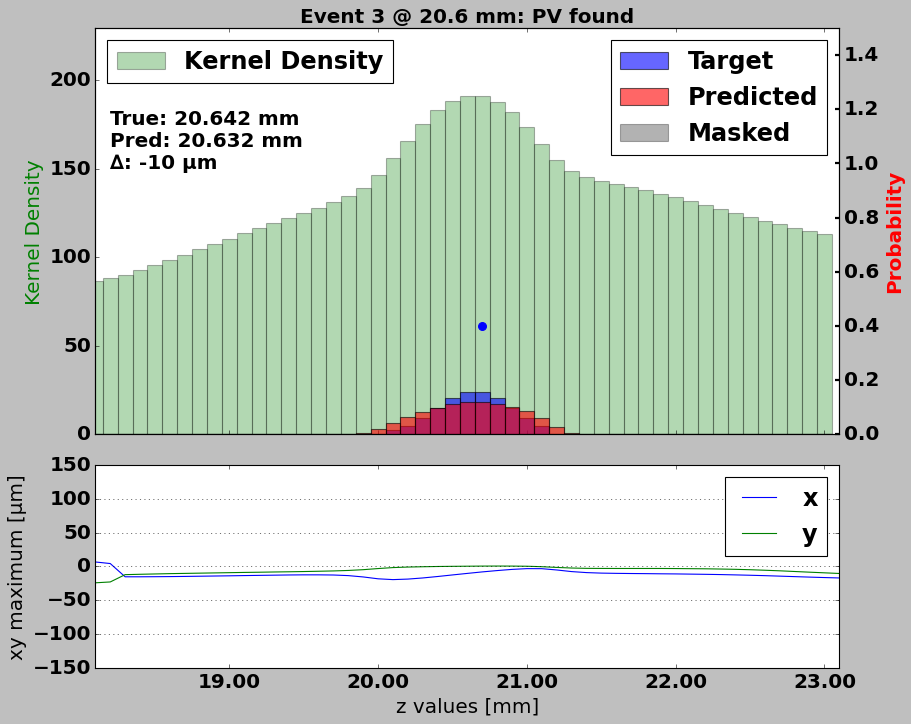

truth_centroid =  [51.88698]
truth_pv_loc[b_truth] =  [1518.8698]
b_truth =  [False  True False False]
truth_pv_loc =  [1206.4215 1518.8698 1565.7228 2763.6868]

comp_centroid =  []
predict_pv_loc[b_comp] =  []
b_comp =  [False False False]
predict_pv_loc =  [1206.319  1565.5825 2762.0063]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  []

Event 3.1:
[34 12  2  0  5  5]
[34 12  2  0  5  5]
[34 12  2  0  5  5]
[34 12  2  0  5  5]
[34 12  2  0  5  5]

PV: 5 tracks (type 1)
  x:    27 μm
  y:    15 μm
  z:   51.948 mm
[34 12  2  0  5  5]


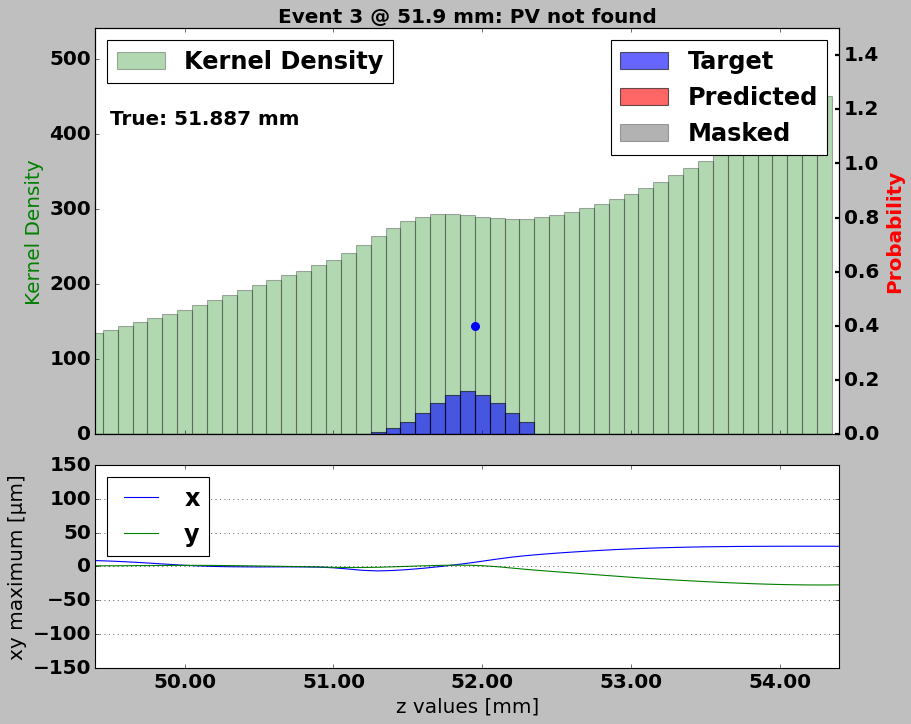

truth_centroid =  [56.57228]
truth_pv_loc[b_truth] =  [1565.7228]
b_truth =  [False False  True False]
truth_pv_loc =  [1206.4215 1518.8698 1565.7228 2763.6868]

comp_centroid =  [56.558258]
predict_pv_loc[b_comp] =  [1565.5825]
b_comp =  [False  True False]
predict_pv_loc =  [1206.319  1565.5825 2762.0063]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [-0.14025879]

Event 3.2:
[34 12  2  0  5  5]

PV: 34 tracks (type 1)
  x:    54 μm
  y:    -5 μm
  z:   56.623 mm
[34 12  2  0  5  5]
[34 12  2  0  5  5]
[34 12  2  0  5  5]
[34 12  2  0  5  5]
[34 12  2  0  5  5]

SV: 0 tracks (type -1)
  x:   292 μm
  y:    -2 μm
  z:   56.545 mm

SV: 0 tracks (type -1)
  x:   -57 μm
  y:   -11 μm
  z:   56.691 mm


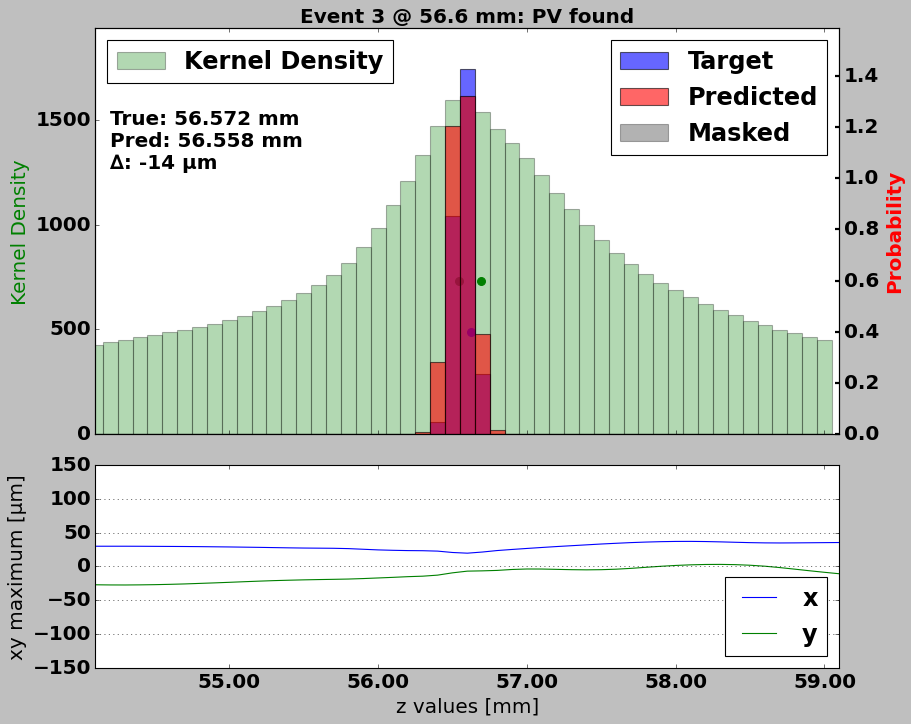

truth_centroid =  [176.36868]
truth_pv_loc[b_truth] =  [2763.6868]
b_truth =  [False False False  True]
truth_pv_loc =  [1206.4215 1518.8698 1565.7228 2763.6868]

comp_centroid =  [176.20062]
predict_pv_loc[b_comp] =  [2762.0063]
b_comp =  [False False  True]
predict_pv_loc =  [1206.319  1565.5825 2762.0063]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [-1.6804199]

Event 3.3:
[34 12  2  0  5  5]
[34 12  2  0  5  5]

PV: 12 tracks (type 1)
  x:   -35 μm
  y:   -29 μm
  z:  176.417 mm
[34 12  2  0  5  5]
[34 12  2  0  5  5]
[34 12  2  0  5  5]
[34 12  2  0  5  5]


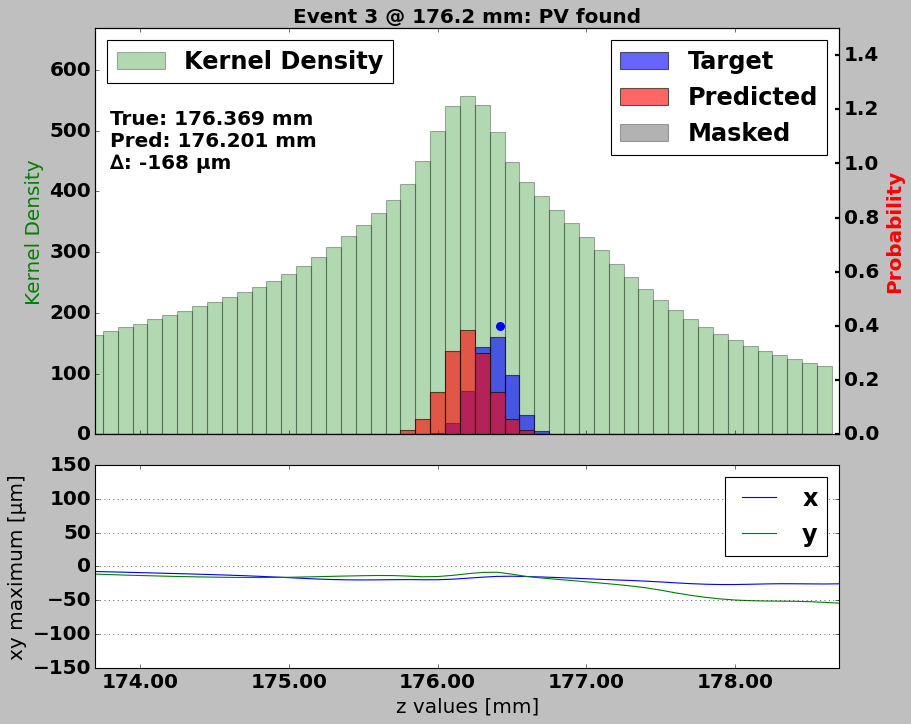

[ 4  0 19  4 46  7 24  8]
4000
truth_pv_loc =  [1709.2887 1730.8313 2154.427  2426.0544 2775.1826]
truth =  [1709 1731 2154 2426 2775]
computed =  [1308 1710 1731 2155 2427 2775]
poi =  [1308 1709 1710 1731 1731 2154 2155 2426 2427 2775 2775]
poi =  [1308 1709 1731 2154 2426 2775]

Event 4: Found 5 of 5, added 0 (eff 100.00%)
truth_centroid =  []
truth_pv_loc[b_truth] =  []
b_truth =  [False False False False False]
truth_pv_loc =  [1709.2887 1730.8313 2154.427  2426.0544 2775.1826]

comp_centroid =  [30.798126]
predict_pv_loc[b_comp] =  [1307.9812]
b_comp =  [ True False False False False False]
predict_pv_loc =  [1307.9812 1709.6453 1731.4036 2154.6912 2426.9617 2774.882 ]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  []

Event 4.0:
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]

PV: 4 tracks (type 0)
  x:    64 μm
  y:   -87 μm
  z:   30.809 mm
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]


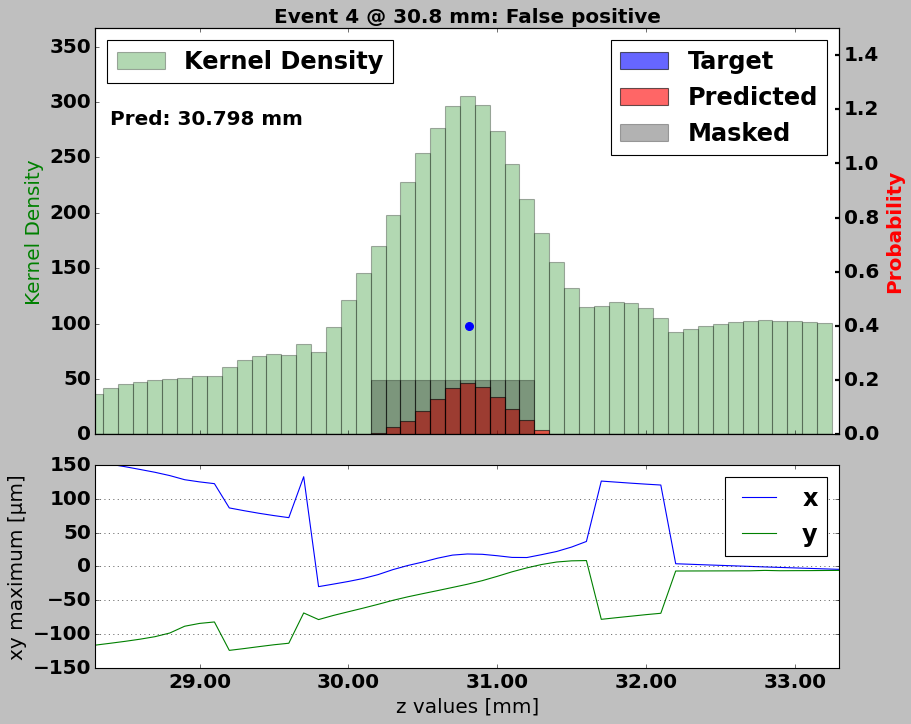

truth_centroid =  [70.92886]
truth_pv_loc[b_truth] =  [1709.2887]
b_truth =  [ True False False False False]
truth_pv_loc =  [1709.2887 1730.8313 2154.427  2426.0544 2775.1826]

comp_centroid =  [70.96452]
predict_pv_loc[b_comp] =  [1709.6453]
b_comp =  [False  True False False False False]
predict_pv_loc =  [1307.9812 1709.6453 1731.4036 2154.6912 2426.9617 2774.882 ]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [0.35656738]

Event 4.1:
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]

PV: 19 tracks (type 1)
  x:   -16 μm
  y:    77 μm
  z:   70.979 mm
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]

PV: 24 tracks (type 1)
  x:   -76 μm
  y:     1 μm
  z:   73.133 mm
[ 4  0 19  4 46  7 24  8]

SV: 2 tracks (type 1)
  x:   -29 μm
  y:    73 μm
  z:   71.329 mm


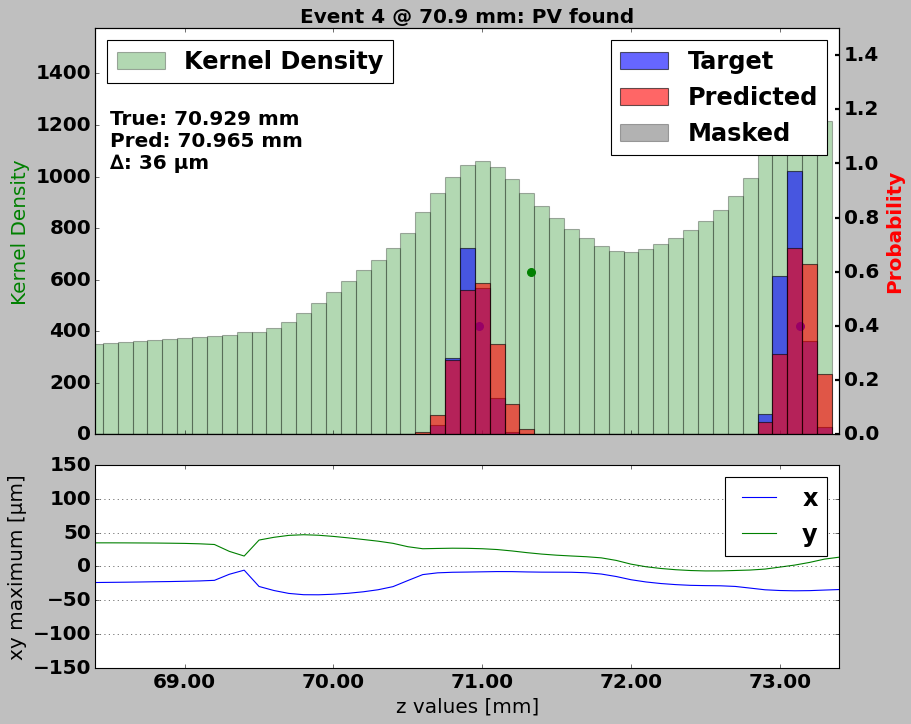

truth_centroid =  [73.08313]
truth_pv_loc[b_truth] =  [1730.8313]
b_truth =  [False  True False False False]
truth_pv_loc =  [1709.2887 1730.8313 2154.427  2426.0544 2775.1826]

comp_centroid =  [73.14035]
predict_pv_loc[b_comp] =  [1731.4036]
b_comp =  [False False  True False False False]
predict_pv_loc =  [1307.9812 1709.6453 1731.4036 2154.6912 2426.9617 2774.882 ]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [0.5722656]

Event 4.2:
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]

PV: 19 tracks (type 1)
  x:   -16 μm
  y:    77 μm
  z:   70.979 mm
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]

PV: 24 tracks (type 1)
  x:   -76 μm
  y:     1 μm
  z:   73.133 mm
[ 4  0 19  4 46  7 24  8]

SV: 2 tracks (type 1)
  x:   -29 μm
  y:    73 μm
  z:   71.329 mm


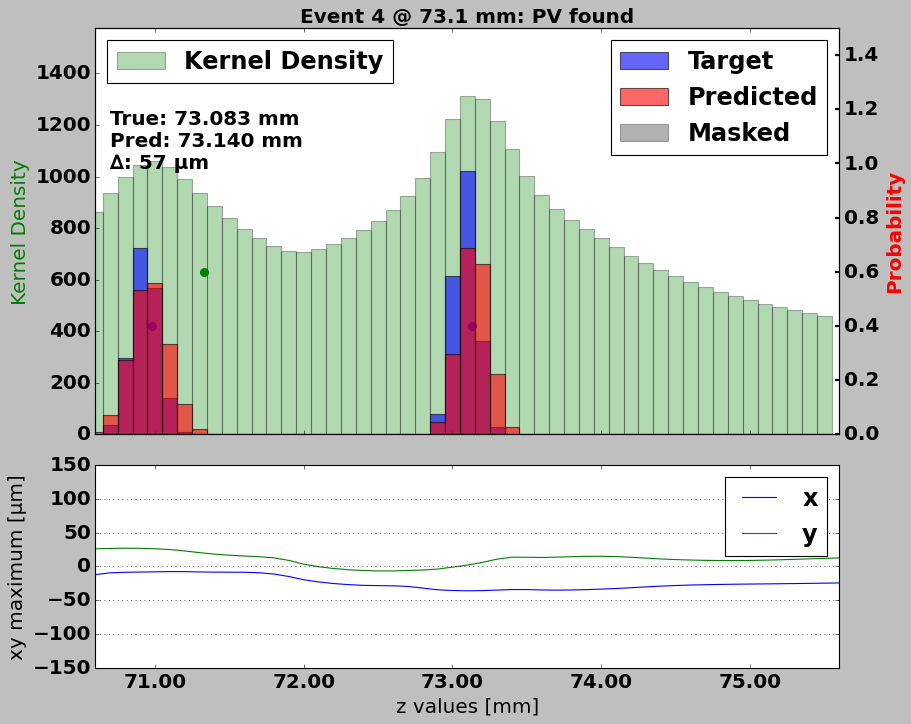

truth_centroid =  [115.4427]
truth_pv_loc[b_truth] =  [2154.427]
b_truth =  [False False  True False False]
truth_pv_loc =  [1709.2887 1730.8313 2154.427  2426.0544 2775.1826]

comp_centroid =  [115.46912]
predict_pv_loc[b_comp] =  [2154.6912]
b_comp =  [False False False  True False False]
predict_pv_loc =  [1307.9812 1709.6453 1731.4036 2154.6912 2426.9617 2774.882 ]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [0.26416016]

Event 4.3:
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]

PV: 46 tracks (type 1)
  x:   -20 μm
  y:   -28 μm
  z:  115.493 mm
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]

SV: 0 tracks (type -1)
  x:  -725 μm
  y:  -597 μm
  z:  113.784 mm

SV: 1 tracks (type 0)
  x:     2 μm
  y:   -27 μm
  z:  115.412 mm


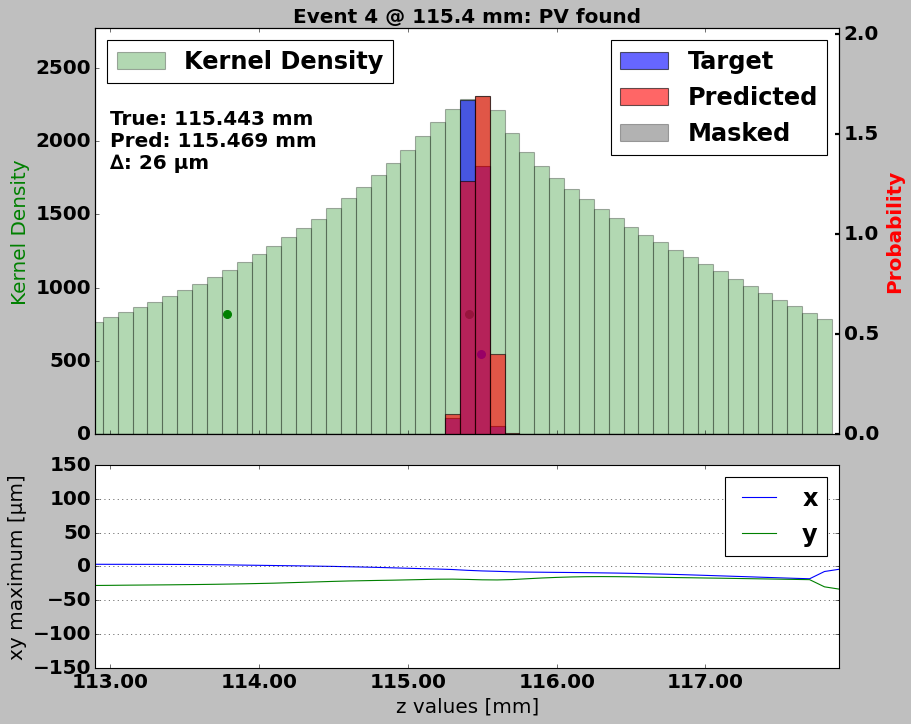

truth_centroid =  [142.60544]
truth_pv_loc[b_truth] =  [2426.0544]
b_truth =  [False False False  True False]
truth_pv_loc =  [1709.2887 1730.8313 2154.427  2426.0544 2775.1826]

comp_centroid =  [142.69617]
predict_pv_loc[b_comp] =  [2426.9617]
b_comp =  [False False False False  True False]
predict_pv_loc =  [1307.9812 1709.6453 1731.4036 2154.6912 2426.9617 2774.882 ]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [0.90722656]

Event 4.4:
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]

PV: 7 tracks (type 1)
  x:    13 μm
  y:    30 μm
  z:  142.656 mm
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]


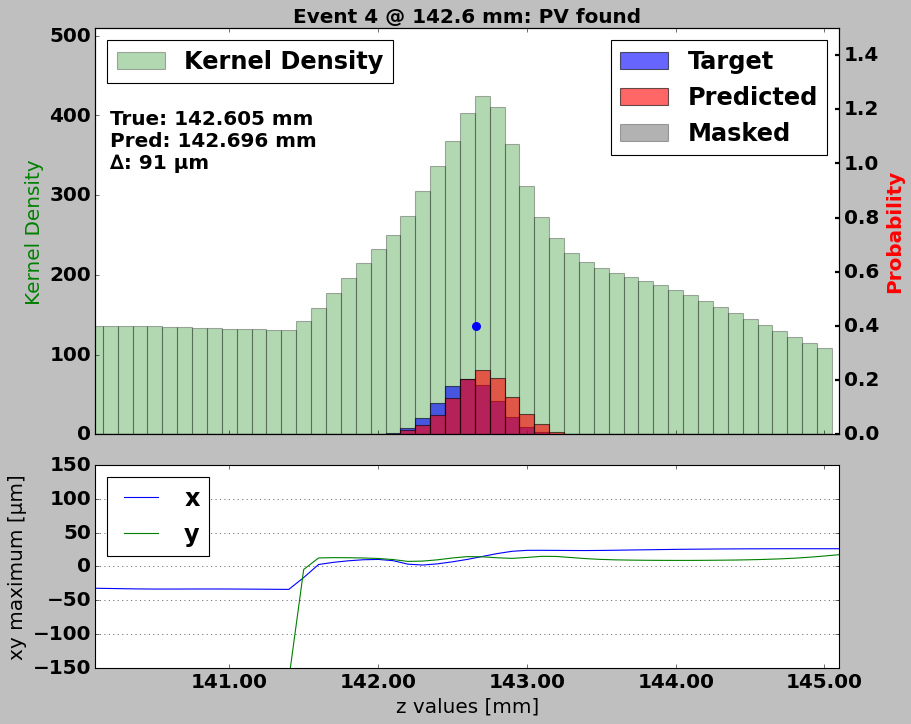

truth_centroid =  [177.51825]
truth_pv_loc[b_truth] =  [2775.1826]
b_truth =  [False False False False  True]
truth_pv_loc =  [1709.2887 1730.8313 2154.427  2426.0544 2775.1826]

comp_centroid =  [177.48822]
predict_pv_loc[b_comp] =  [2774.882]
b_comp =  [False False False False False  True]
predict_pv_loc =  [1307.9812 1709.6453 1731.4036 2154.6912 2426.9617 2774.882 ]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [-0.3005371]

Event 4.5:
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]
[ 4  0 19  4 46  7 24  8]

PV: 8 tracks (type 1)
  x:   -14 μm
  y:   -49 μm
  z:  177.570 mm


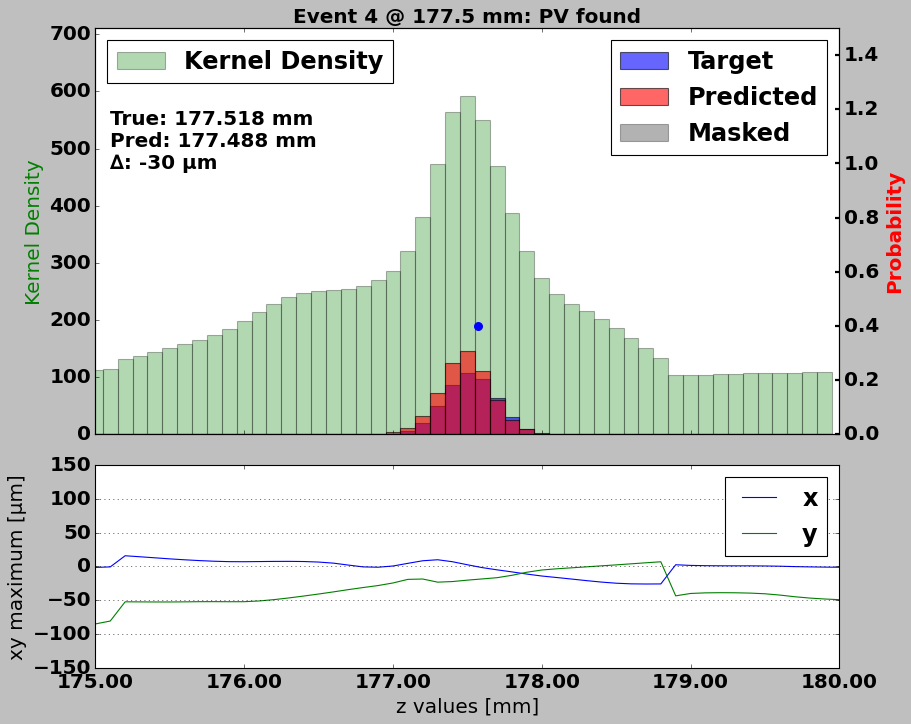

[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
4000
truth_pv_loc =  [1103.6902 1190.1088 1755.8812 2052.5537 2148.4985 2478.8738 2974.5989
 3215.837 ]
truth =  [1104 1190 1756 2053 2148 2479 2975 3216]
computed =  [1104 1190 1756 2055 2148 2479 2974 3216]
poi =  [1104 1104 1190 1190 1756 1756 2053 2055 2148 2148 2479 2479 2974 2975
 3216 3216]
poi =  [1104 1190 1756 2053 2148 2479 2974 3216]

Event 5: Found 8 of 8, added 0 (eff 100.00%)
truth_centroid =  [10.369019]
truth_pv_loc[b_truth] =  [1103.6902]
b_truth =  [ True False False False False False False False]
truth_pv_loc =  [1103.6902 1190.1088 1755.8812 2052.5537 2148.4985 2478.8738 2974.5989
 3215.837 ]

comp_centroid =  [10.435097]
predict_pv_loc[b_comp] =  [1104.351]
b_comp =  [ True False False False False False False False]
predict_pv_loc =  [1104.351  1189.7484 1755.9247 2055.4238 2148.1147 2479.2485 2973.8923
 3215.5378]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [0.6607666]

Event 5.0:
[ 0  0  0  4  8  6  0 28  

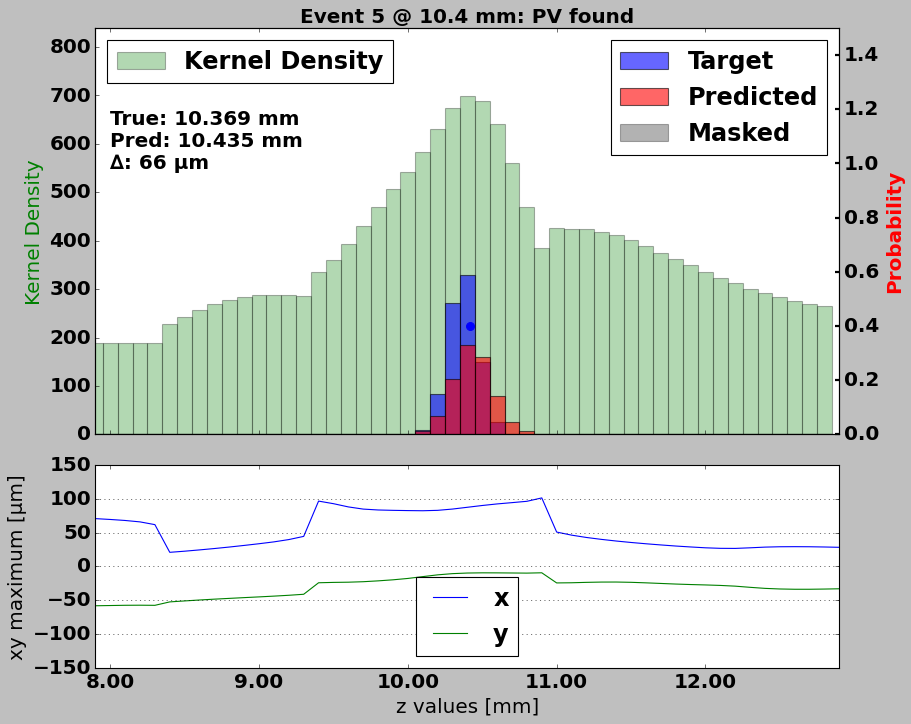

truth_centroid =  [19.01088]
truth_pv_loc[b_truth] =  [1190.1088]
b_truth =  [False  True False False False False False False]
truth_pv_loc =  [1103.6902 1190.1088 1755.8812 2052.5537 2148.4985 2478.8738 2974.5989
 3215.837 ]

comp_centroid =  [18.974838]
predict_pv_loc[b_comp] =  [1189.7484]
b_comp =  [False  True False False False False False False]
predict_pv_loc =  [1104.351  1189.7484 1755.9247 2055.4238 2148.1147 2479.2485 2973.8923
 3215.5378]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [-0.36035156]

Event 5.1:
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]

PV: 0 tracks (typ

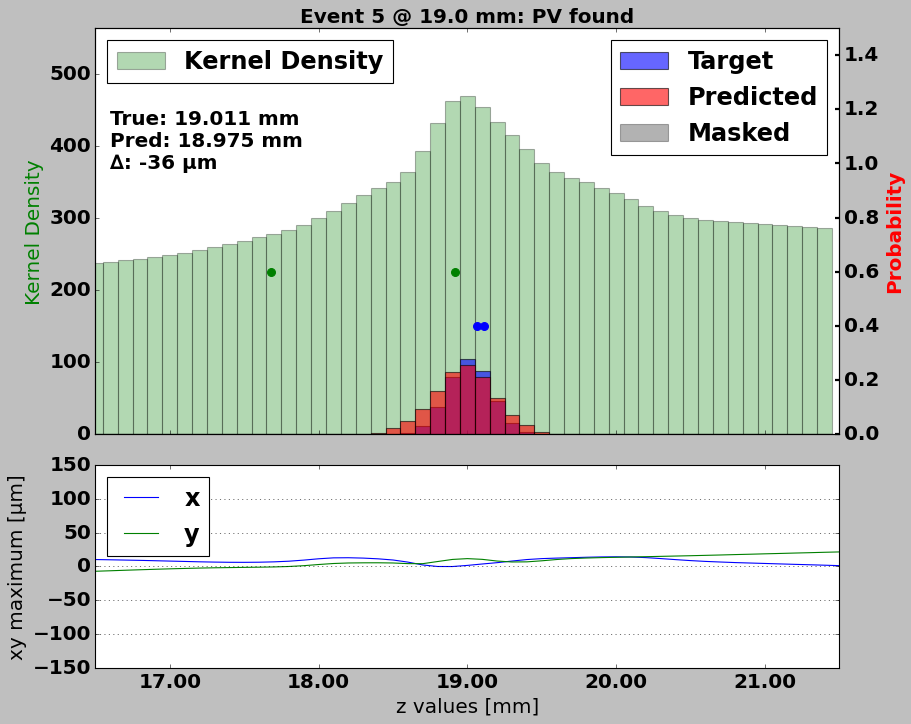

truth_centroid =  [75.58812]
truth_pv_loc[b_truth] =  [1755.8812]
b_truth =  [False False  True False False False False False]
truth_pv_loc =  [1103.6902 1190.1088 1755.8812 2052.5537 2148.4985 2478.8738 2974.5989
 3215.837 ]

comp_centroid =  [75.59247]
predict_pv_loc[b_comp] =  [1755.9247]
b_comp =  [False False  True False False False False False]
predict_pv_loc =  [1104.351  1189.7484 1755.9247 2055.4238 2148.1147 2479.2485 2973.8923
 3215.5378]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [0.04345703]

Event 5.2:
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  

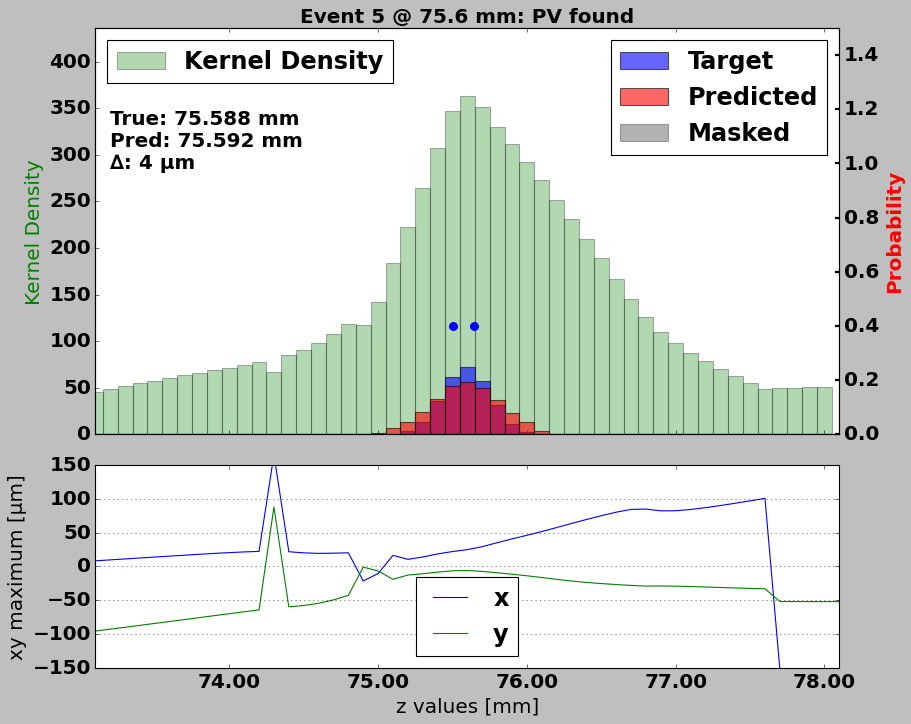

truth_centroid =  [105.25537]
truth_pv_loc[b_truth] =  [2052.5537]
b_truth =  [False False False  True False False False False]
truth_pv_loc =  [1103.6902 1190.1088 1755.8812 2052.5537 2148.4985 2478.8738 2974.5989
 3215.837 ]

comp_centroid =  [105.54239]
predict_pv_loc[b_comp] =  [2055.4238]
b_comp =  [False False False  True False False False False]
predict_pv_loc =  [1104.351  1189.7484 1755.9247 2055.4238 2148.1147 2479.2485 2973.8923
 3215.5378]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [2.8701172]

Event 5.3:
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]

PV: 0 tracks (type -1)
  x:    69 μm
  y:   -30 μm
  z:  105.255 mm
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]


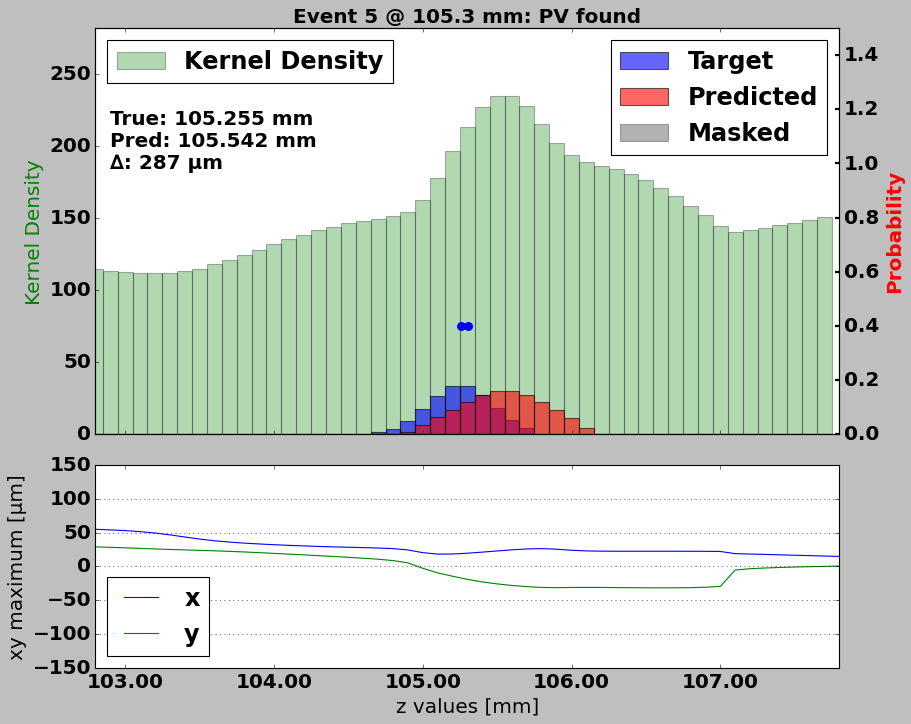

truth_centroid =  [114.84985]
truth_pv_loc[b_truth] =  [2148.4985]
b_truth =  [False False False False  True False False False]
truth_pv_loc =  [1103.6902 1190.1088 1755.8812 2052.5537 2148.4985 2478.8738 2974.5989
 3215.837 ]

comp_centroid =  [114.81148]
predict_pv_loc[b_comp] =  [2148.1147]
b_comp =  [False False False False  True False False False]
predict_pv_loc =  [1104.351  1189.7484 1755.9247 2055.4238 2148.1147 2479.2485 2973.8923
 3215.5378]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [-0.38378906]

Event 5.4:
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]

PV: 6 tracks (type 1)
  x:   -12 μm
  y:   -23 μm
  z:  114.900 mm
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]

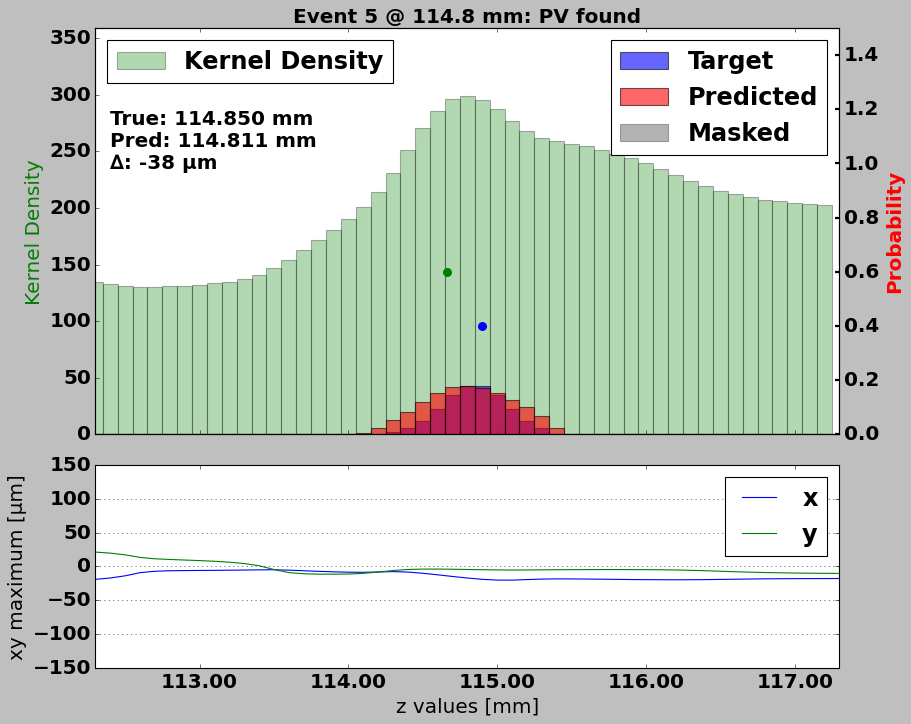

truth_centroid =  [147.88737]
truth_pv_loc[b_truth] =  [2478.8738]
b_truth =  [False False False False False  True False False]
truth_pv_loc =  [1103.6902 1190.1088 1755.8812 2052.5537 2148.4985 2478.8738 2974.5989
 3215.837 ]

comp_centroid =  [147.92485]
predict_pv_loc[b_comp] =  [2479.2485]
b_comp =  [False False False False False  True False False]
predict_pv_loc =  [1104.351  1189.7484 1755.9247 2055.4238 2148.1147 2479.2485 2973.8923
 3215.5378]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [0.37475586]

Event 5.5:
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]

PV: 28 tracks (type 1)
  x:    46 μm
  y:   123 μm
  z:  147.937 mm

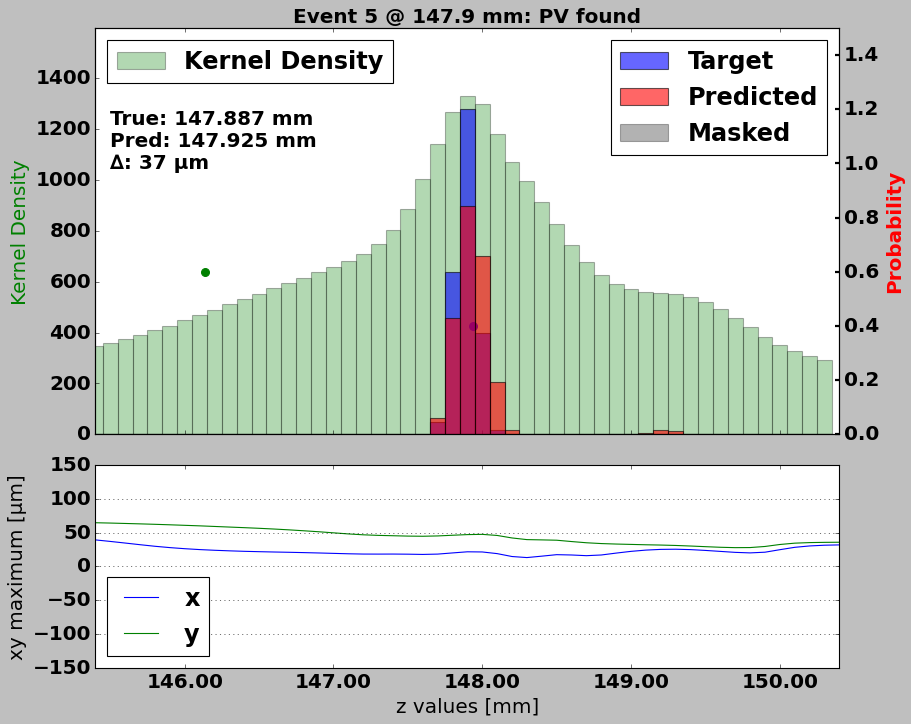

truth_centroid =  [197.4599]
truth_pv_loc[b_truth] =  [2974.5989]
b_truth =  [False False False False False False  True False]
truth_pv_loc =  [1103.6902 1190.1088 1755.8812 2052.5537 2148.4985 2478.8738 2974.5989
 3215.837 ]

comp_centroid =  [197.38922]
predict_pv_loc[b_comp] =  [2973.8923]
b_comp =  [False False False False False False  True False]
predict_pv_loc =  [1104.351  1189.7484 1755.9247 2055.4238 2148.1147 2479.2485 2973.8923
 3215.5378]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [-0.70654297]

Event 5.6:
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]

PV: 8 tracks (type 1)
  x:    -6 μm
  y:   -62 μm
  z:  197.511 mm
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]


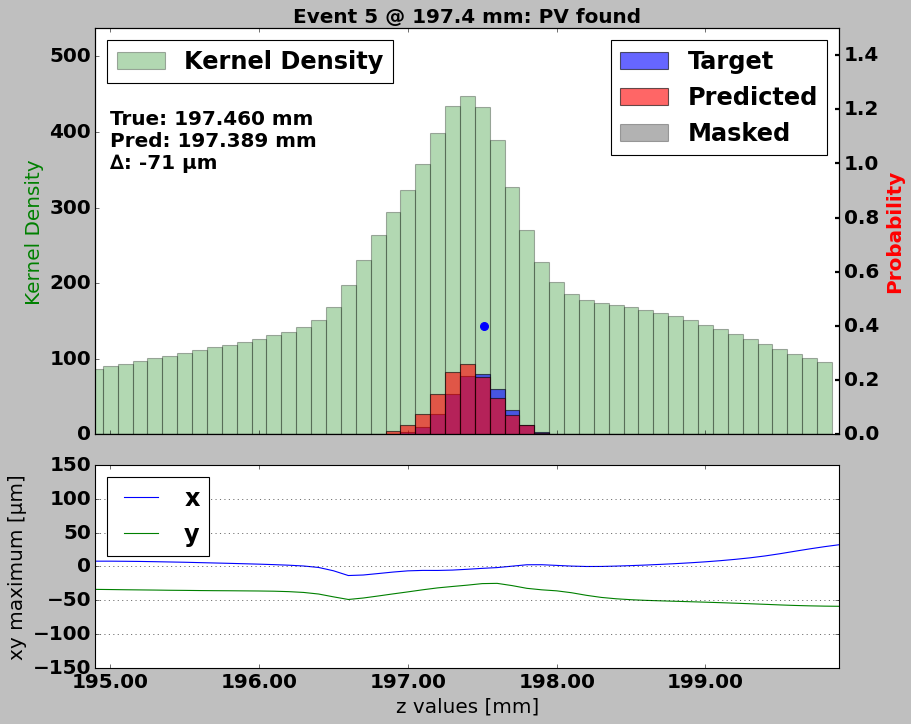

truth_centroid =  [221.58368]
truth_pv_loc[b_truth] =  [3215.837]
b_truth =  [False False False False False False False  True]
truth_pv_loc =  [1103.6902 1190.1088 1755.8812 2052.5537 2148.4985 2478.8738 2974.5989
 3215.837 ]

comp_centroid =  [221.55377]
predict_pv_loc[b_comp] =  [3215.5378]
b_comp =  [False False False False False False False  True]
predict_pv_loc =  [1104.351  1189.7484 1755.9247 2055.4238 2148.1147 2479.2485 2973.8923
 3215.5378]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [-0.29907227]

Event 5.7:
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6  0 28  0 17  5  6  9  0 10  2]
[ 0  0  0  4  8  6

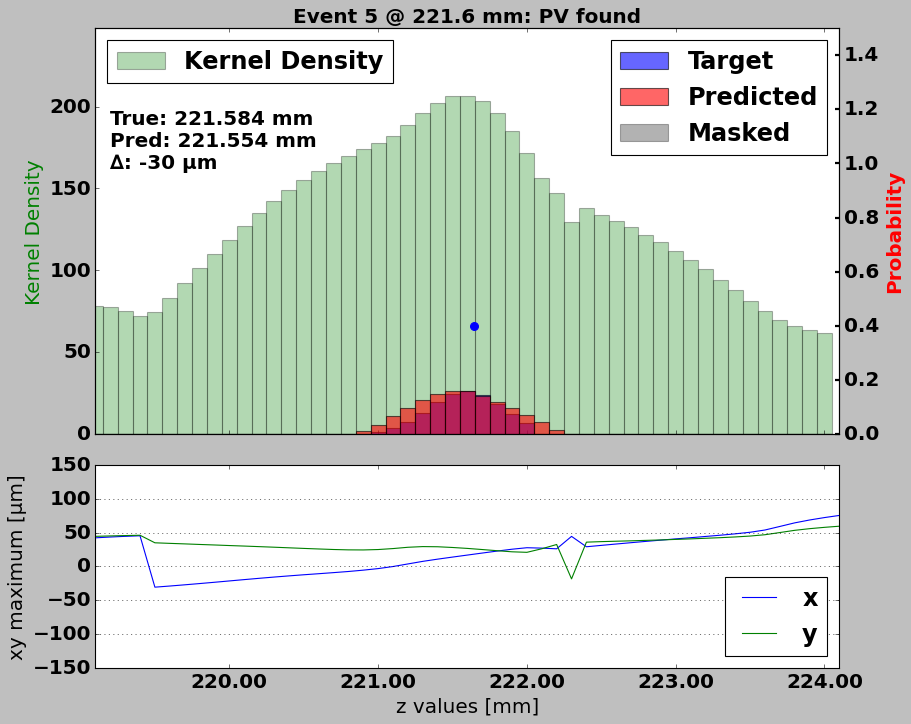

[39  3  0  0  9 43  0 22 31 31  0 27]
4000
truth_pv_loc =  [1360.6903 1367.4515 2293.357  2432.2292 2506.5015 2795.599  2940.8926]
truth =  [1361 1367 2293 2432 2507 2796 2941]
computed =  [1364 2293 2432 2504 2796 2941]
poi =  [1361 1364 1367 2293 2293 2432 2432 2504 2507 2796 2796 2941 2941]
poi =  [1361 2293 2432 2504 2796 2941]

Event 6: Found 7 of 7, added 0 (eff 100.00%)
truth_centroid =  [36.06903]
truth_pv_loc[b_truth] =  [1360.6903]
b_truth =  [ True False False False False False False]
truth_pv_loc =  [1360.6903 1367.4515 2293.357  2432.2292 2506.5015 2795.599  2940.8926]

comp_centroid =  [36.38858]
predict_pv_loc[b_comp] =  [1363.8859]
b_comp =  [ True False False False False False]
predict_pv_loc =  [1363.8859 2293.3403 2431.9934 2504.3235 2795.8967 2941.3877]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [3.1955566]

Event 6.0:
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31

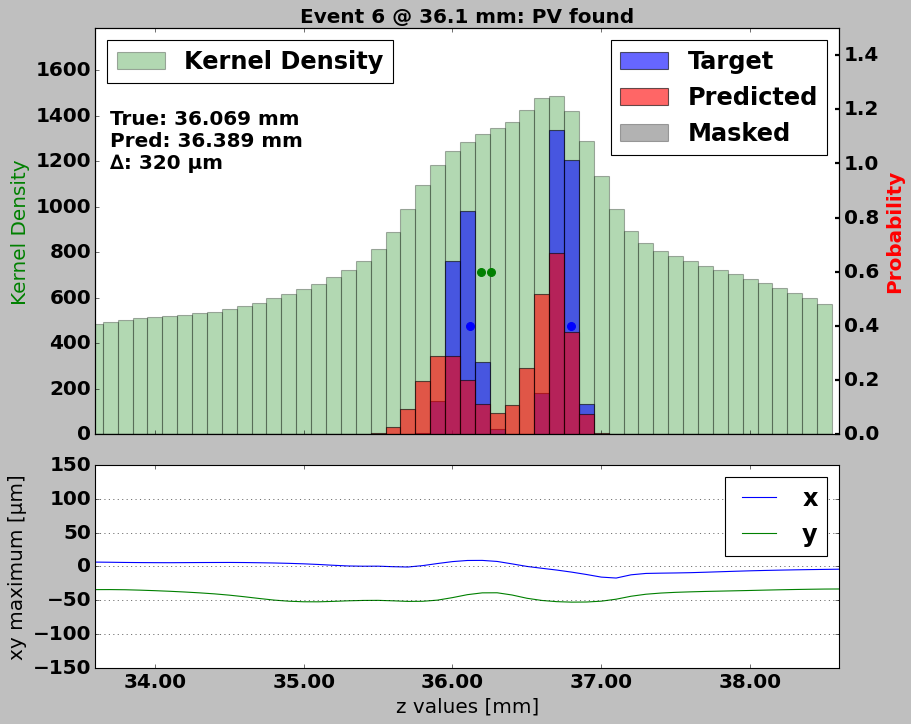

truth_centroid =  [129.3357]
truth_pv_loc[b_truth] =  [2293.357]
b_truth =  [False False  True False False False False]
truth_pv_loc =  [1360.6903 1367.4515 2293.357  2432.2292 2506.5015 2795.599  2940.8926]

comp_centroid =  [129.33403]
predict_pv_loc[b_comp] =  [2293.3403]
b_comp =  [False  True False False False False]
predict_pv_loc =  [1363.8859 2293.3403 2431.9934 2504.3235 2795.8967 2941.3877]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [-0.01660156]

Event 6.1:
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]

PV: 31 tracks (type 1)
  x:   -65 μm
  y:  -105 μm
  z:  129.385 mm
[39  3  0  0  9 43  0 22 31 31  0 27]

PV: 0 tracks (type -1)
  x:   -

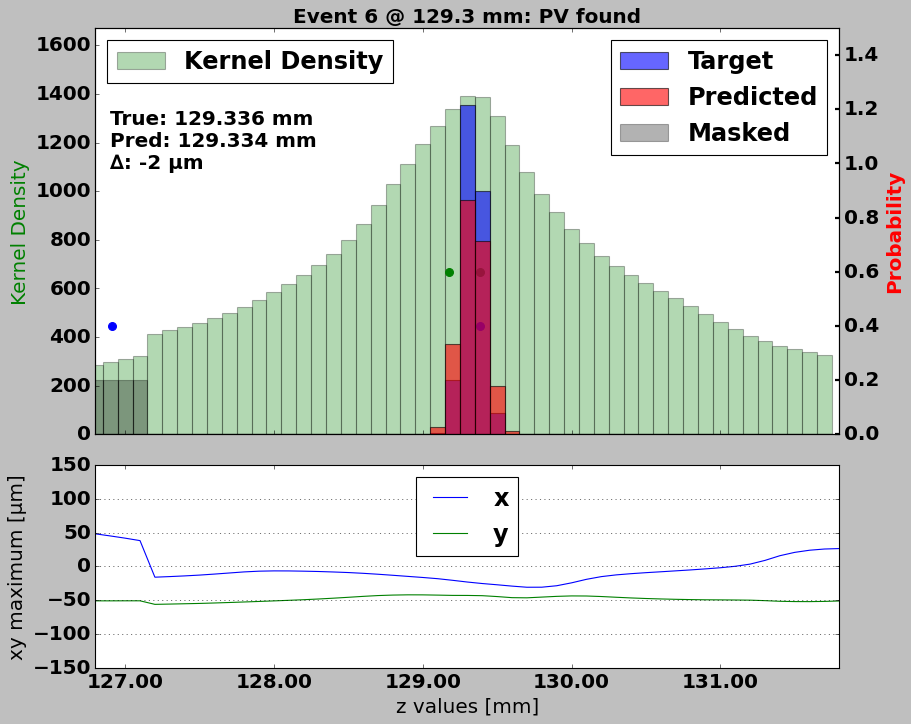

truth_centroid =  [143.22293]
truth_pv_loc[b_truth] =  [2432.2292]
b_truth =  [False False False  True False False False]
truth_pv_loc =  [1360.6903 1367.4515 2293.357  2432.2292 2506.5015 2795.599  2940.8926]

comp_centroid =  [143.19934]
predict_pv_loc[b_comp] =  [2431.9934]
b_comp =  [False False  True False False False]
predict_pv_loc =  [1363.8859 2293.3403 2431.9934 2504.3235 2795.8967 2941.3877]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [-0.23583984]

Event 6.2:
[39  3  0  0  9 43  0 22 31 31  0 27]

PV: 39 tracks (type 1)
  x:   -28 μm
  y:    78 μm
  z:  143.273 mm
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31

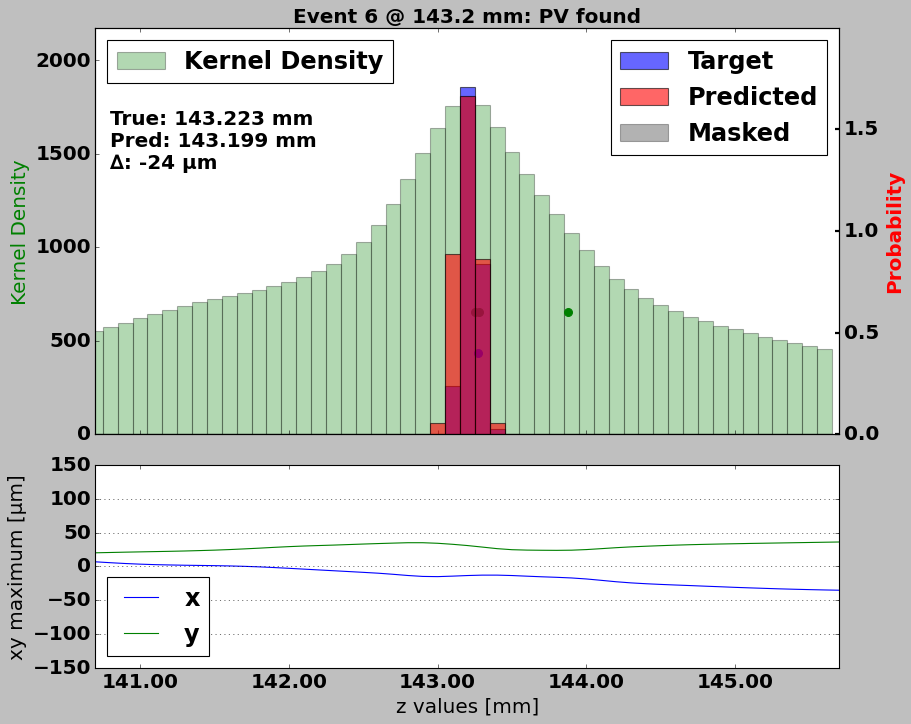

truth_centroid =  [150.65015]
truth_pv_loc[b_truth] =  [2506.5015]
b_truth =  [False False False False  True False False]
truth_pv_loc =  [1360.6903 1367.4515 2293.357  2432.2292 2506.5015 2795.599  2940.8926]

comp_centroid =  [150.43234]
predict_pv_loc[b_comp] =  [2504.3235]
b_comp =  [False False False  True False False]
predict_pv_loc =  [1363.8859 2293.3403 2431.9934 2504.3235 2795.8967 2941.3877]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [-2.1779785]

Event 6.3:
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]

PV: 9 tracks (type 1)
  x:    35 μm
  y:   -31 μm
  z:  150.700 mm
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  

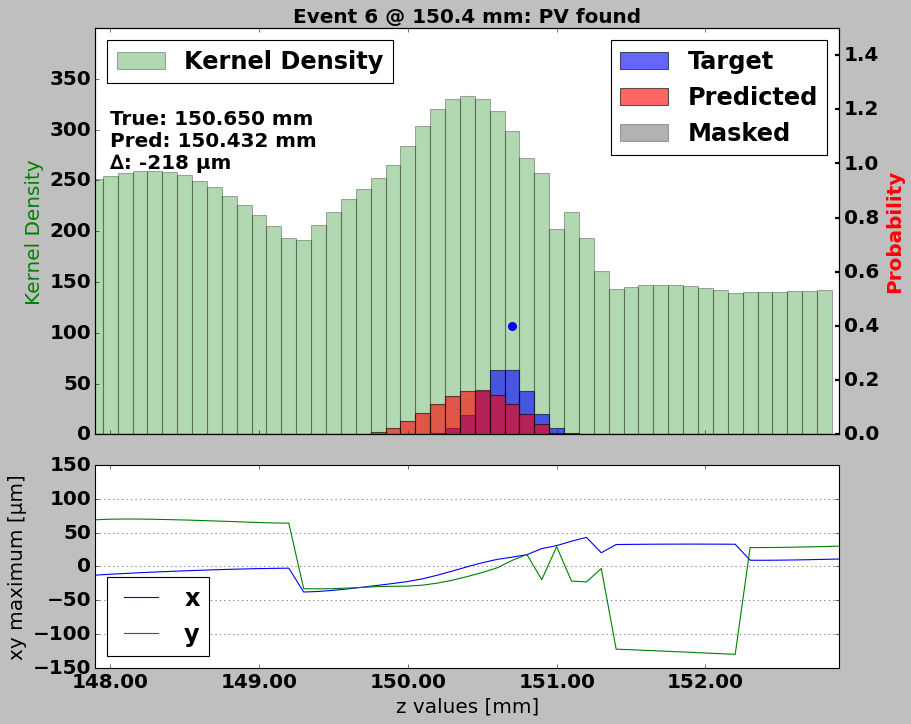

truth_centroid =  [179.5599]
truth_pv_loc[b_truth] =  [2795.599]
b_truth =  [False False False False False  True False]
truth_pv_loc =  [1360.6903 1367.4515 2293.357  2432.2292 2506.5015 2795.599  2940.8926]

comp_centroid =  [179.58966]
predict_pv_loc[b_comp] =  [2795.8967]
b_comp =  [False False False False  True False]
predict_pv_loc =  [1363.8859 2293.3403 2431.9934 2504.3235 2795.8967 2941.3877]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [0.29760742]

Event 6.4:
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]

PV: 43 tracks (type 1)
  x:   -52 μm
  y:    32 μm
  z:  179.610 mm
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0

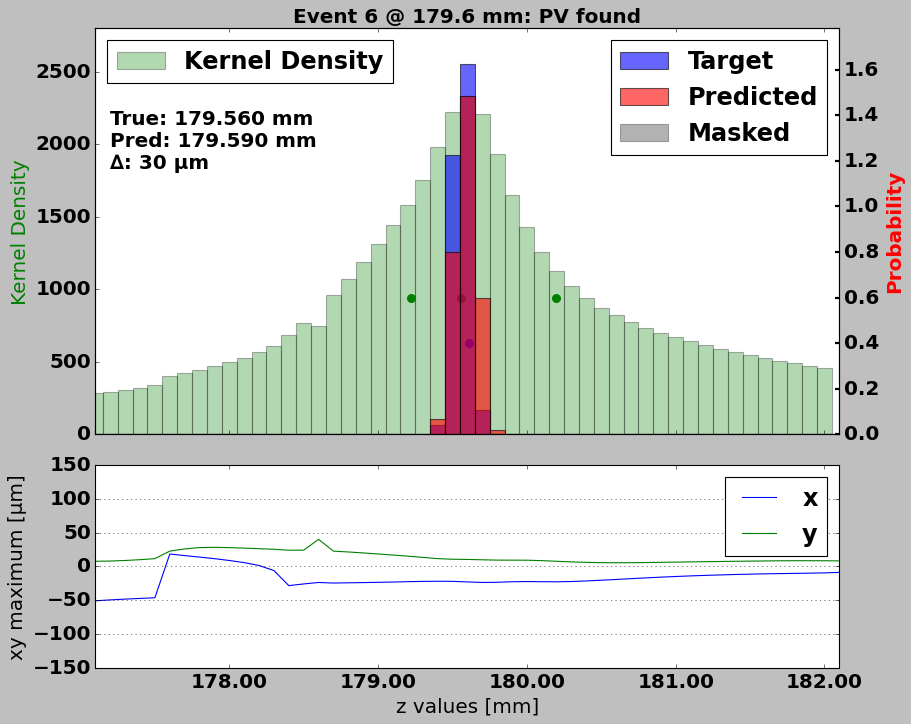

truth_centroid =  [194.08926]
truth_pv_loc[b_truth] =  [2940.8926]
b_truth =  [False False False False False False  True]
truth_pv_loc =  [1360.6903 1367.4515 2293.357  2432.2292 2506.5015 2795.599  2940.8926]

comp_centroid =  [194.13876]
predict_pv_loc[b_comp] =  [2941.3877]
b_comp =  [False False False False False  True]
predict_pv_loc =  [1363.8859 2293.3403 2431.9934 2504.3235 2795.8967 2941.3877]

predict_pv_loc[b_comp] - truth_pv_loc[b_truth] =  [0.4951172]

Event 6.5:
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]
[39  3  0  0  9 43  0 22 31 31  0 27]

PV: 27 tracks (type 1)
  x:   -39 μm
  y:    46 μm
  z:  194.1

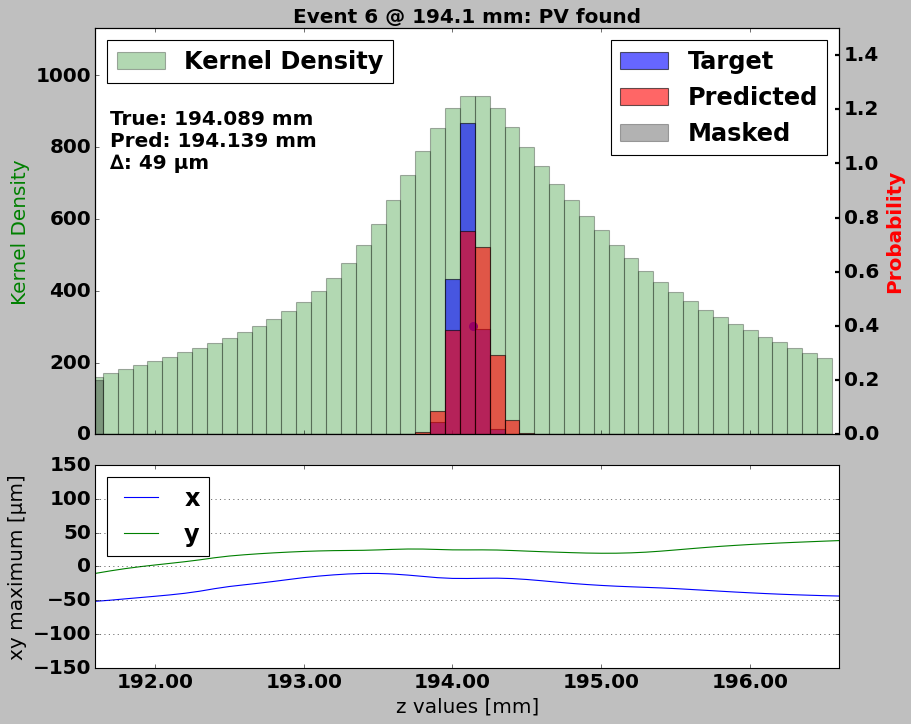

In [17]:
inputs = validation.dataset.tensors[0].cpu().numpy()[:,0,:]
if verbose:
    print(' = ',inputs)

## zvals is used in Rui's plotting script  
zvals = np.linspace(-100, 300, 4000, endpoint=False) + 0.05

internal_count = 0
output_filename = None # Or set: '120000_3layer_{number:02}.pdf'


for event in range(7):
    input = inputs[event]
    truth_kdes = truth_inputs[event]
    predict_kdes = predict_outputs[event]
    
    nTracks = PV.n[event]
    print(nTracks)
    
    # Consistent parameters for the calls below
    parameters = {
        "threshold": 1e-2,
        "integral_threshold": .2,
        "min_width": 3
    }
    
    # Compute the "actual" efficenies and things
    print(len(truth_kdes))
    truth_pv_loc = pv_locations(truth_kdes, **parameters)
    print("truth_pv_loc = ",truth_pv_loc)
    predict_pv_loc = pv_locations(predict_kdes, **parameters)
    effi = efficiency(truth_kdes, predict_kdes, difference=5.0, **parameters)
    
    
    # Make sure bin numbers are integers
    truth = np.around(truth_pv_loc).astype(np.int32)
    print("truth = ",truth)
    computed = np.around(predict_pv_loc).astype(np.int32)
    print("computed = ",computed)
    
    # Join arrays and remove any points closer than 5 bins
    # We plot over these "points of interest"
    poi = np.sort(np.concatenate([truth, computed]))
    print("poi = ",poi)
    poi = poi[np.concatenate([[True], np.fabs(np.diff(poi)) > 5])]
    
    print("poi = ",poi)
    
    print(f"\nEvent {event}:", effi)
    
    for index, i in enumerate(poi):
        # Convert to location in z
        center = (i / 10) - 100
        
        # Collect items less than 5 apart as "true"
        b_truth = np.fabs(truth_pv_loc - i) <= 5
        b_comp = np.fabs(predict_pv_loc - i) <= 5
        in_truth = np.any(b_truth)
        in_comp = np.any(b_comp)
        
        if in_truth and in_comp:
            msg = 'PV found'
        elif in_truth:
            msg = 'PV not found'
        elif False:
            pass # Check for NaNs
        else:
            msg = 'False positive'
            
        with plt.style.context({
            'font.size':18,
            'font.weight':'bold'}):
        
            fig, axs = plt.subplots(2, figsize=(12,10), sharex=True,
                                    gridspec_kw={'height_ratios':[2,1],
                                                'hspace':0.1})
        
            # ax1 is the axis that is tied to left (density)
            # ax2 is the axis that is tied to the right (probability)
            ax1, ax2 = plot_ruiplot(zvals, i, input, truth_kdes, predict_kdes, ax=axs[0])
            ax1.set_title(f"Event {event} @ {center:.1f} mm: {msg}",
                          fontdict={'size':18, 'weight':'bold'})


            msg = ""
            
            truth_centroid = (truth_pv_loc[b_truth] / 10) - 100
            print("truth_centroid = ", truth_centroid)
            print("truth_pv_loc[b_truth] = ", truth_pv_loc[b_truth])
            print("b_truth = ", b_truth)
            print("truth_pv_loc = ", truth_pv_loc)
            print("")

            for value in truth_centroid:
                msg += f"True: {value:.3f} mm\n"
                
            comp_centroid = (predict_pv_loc[b_comp] / 10) - 100
            print("comp_centroid = ",comp_centroid)
            print("predict_pv_loc[b_comp] = ", predict_pv_loc[b_comp])
            print("b_comp = ", b_comp)
            print("predict_pv_loc = ", predict_pv_loc)
            print("")
            print("predict_pv_loc[b_comp] - truth_pv_loc[b_truth] = ", (predict_pv_loc[b_comp] - truth_pv_loc[b_truth]))
            
            for value in comp_centroid:
                msg += f"Pred: {value:.3f} mm\n"
                
            if len(truth_centroid) == 1 and len(comp_centroid) == 1:
                diff = (comp_centroid[0] - truth_centroid[0]) * 1_000
                msg += f"∆: {diff:.0f} µm\n"
            
            ax1.text(.02, .8, msg,
                     transform=ax1.transAxes,
                     verticalalignment='top')
            
            print(f"\nEvent {event}.{index}:")
            
            # Plot and print PVs
            ax2.scatter(PV.z[event], np.ones_like(PV.z[event])*.4, s=50, color='C0')
            for x,y,z,n,cat in zip(PV.x[event], PV.y[event], PV.z[event], PV.n[event], PV.cat[event]):
                # Only print out if z in plotting range
                print(PV.n[event])
                if center - 2.5 < z < center + 2.5:
                    print()
                    print(f'PV: {n} tracks (type {cat})')
                    print(f'  x: {x*1000:5.0f} μm')
                    print(f'  y: {y*1000:5.0f} μm')
                    print(f'  z: {z:8.3f} mm')
                    

            # Plot and print SVs
            ax2.scatter(SV.z[event], np.ones_like(SV.z[event])*.6, s=50, color='C1')
            for x,y,z,n,cat in zip(SV.x[event], SV.y[event], SV.z[event], SV.n[event], SV.cat[event]):
                # Only print out if z in plotting range
                if center - 2.5 < z < center + 2.5:
                    print()
                    print(f'SV: {n} tracks (type {cat})')
                    print(f'  x: {x*1000:5.0f} μm')
                    print(f'  y: {y*1000:5.0f} μm')
                    print(f'  z: {z:8.3f} mm')
            
            ax = axs[1]
            ax.plot((np.arange(4000) / 10) - 100, xmax[event]*1000000, label="x")
            ax.plot((np.arange(4000) / 10) - 100, ymax[event]*1000000, label="y")
            ax.set_xlim(ax1.get_xlim())
            ax.set_ylim(-150,150)
            ax.grid(axis='y')
            ax.set_ylabel('xy maximum [μm]')
            ax.legend(loc='best')
            
            ax.set_xlabel(ax1.get_xlabel())
            ax1.set_xlabel("")
            
            # Save and show
            if output_filename:        
                plt.savefig(output_filename.format(number=internal_count))
            plt.show()
            
            internal_count += 1
            
#print(finalmsg)